In [1]:
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import re

def spellProcessor(word):
    word = word.lower()
    word = word.replace("gyftis", "gifts")
    word = word.replace("gether", "gather")
    word = word.replace("spirituall", "spiritual")
    word = word.replace("feythfull", "faith")
    word = word.replace("wytnes", "witness")
    word = word.replace("almes", "alms")
    word = word.replace("desyre", "desire")
    word = word.replace("selfe", "self")
    word = word.replace("saffely", "safely")
    word = word.replace("realme", "realm")
    word = word.replace("acte", "act")
    word = word.replace("fourme", "form")
    word = word.replace("subiectes", "subjects")
    word = word.replace("theyr", "their")
    word = word.replace("kynde", "kind")
    word = word.replace("kynge", "king")
    word = word.replace("kyndes", "kinds")
    word = word.replace("vpon", "unto")
    word = word.replace("purueyours", "purveyors")
    word = word.replace("highnes", "highness")
    word = word.replace("euery", "every")
    word = word.replace("quene", "queen")
    word = word.replace("quenes", "queens")
    word = word.replace("whiche", "which")
    word = word.replace("bloude", "blood")
    word = word.replace("soueraine", "sovereign")
    word = word.replace("enactd", "enacted")
    word = word.replace("vs", "us")
    
    word = re.sub('\d','', word)
    return word

stopWords = [",","the","and","of","or","to","in","shall","be","that","any","by",".",
              "such","as","this","for","same","all","said","other","'s",";",
              "her","is","every","[","]","they","within", "our", "not", "so",
              "made", "no", "then", ":", "do", "from", "if", "it", "which", "at", "with",
             "thereof","upon", "a", "because", "used", "some", "but", "aforesaid", "also",
             ")","(", "what", "&", "may", "are", "their", "them", "sayde", "suche", "shalbe", "anye", "sayd",
             "thesaid", "/", "...", "/", "either", "haue", "vnto", "thy", "did", "was", "were", "have", "thee", 
             "your", "thou", "unto", "hath", "had", "went","kl"]

In [2]:
input_data = list()
row_count = 0

metadata=list()
with open('../vtexts/vtextMetadata.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # deal with the header
        if row_count != 0:
            metadata.append(row)   
        row_count += 1
print("read",row_count,"lines")

read 70 lines


In [3]:
# change to sovereign
labels = [i[3] for i in metadata]
files = list()
for i in metadata:
    fn = "../vtexts/" + i[0]
    files.append(fn)
    
vectorizer = CountVectorizer(
    input='filename',
    lowercase=True,
    ngram_range=(1,3),
    strip_accents=None, 
    preprocessor=spellProcessor, 
    stop_words=stopWords)

In [4]:
# get document term matrix
dtm = vectorizer.fit_transform(files)

# convert to tf-idf frequencies (to account for differences in text lengths)
tfidf_transformer = TfidfTransformer()
dtm_tfidf = tfidf_transformer.fit_transform(dtm)

In [5]:
# attempt to deal with imbalanced dataset
for c in set(labels):
    print("Class: {0}, Documents: {1}".format(c,labels.count(c)))

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                     np.unique(labels),
                                     labels)

Class: James I, Documents: 7
Class: Mary I, Documents: 8
Class: Henry VIII, Documents: 14
Class: Elizabeth I, Documents: 18
Class: Charles I, Documents: 12
Class: Charles II, Documents: 1
Class: Edward VI, Documents: 9


In [6]:
# create and fit model using Support Vector Machine (SVM)
clf = SGDClassifier(tol=None,class_weight="balanced",max_iter=1000).fit(dtm_tfidf, labels)

In [7]:
# this function will return total count of a term in the vocabulary
def get_counts(term):
    widx = vectorizer.vocabulary_[term]
    return(dtm.sum(axis=0)[0,widx])

def get_class_representation(term):
    widx = vectorizer.vocabulary_[term]
    cd = dict()
    
    # initialize
    for c in set(labels):
        cd[c] = 0
    for i,c in enumerate(labels):
        cd[c] += dtm[i,widx]
    return(cd)

In [8]:
# what are our top terms?
vocab_sums = dtm.sum(axis=0)
sorted_vocab = [(v, vocab_sums[0, i]) for v, i in vectorizer.vocabulary_.items()]
sorted_vocab = sorted(sorted_vocab, key = lambda x: x[1], reverse=True)

# display top twenty words
for i in range(1,20):
    print(sorted_vocab[i][0],"->",sorted_vocab[i][1])

his -> 14569
lord -> 11686
him -> 9700
god -> 7949
my -> 7709
will -> 6057
me -> 5780
we -> 5768
you -> 5019
there -> 4972
ye -> 4916
day -> 4756
man -> 4620
when -> 4504
men -> 4238
king -> 4157
one -> 4121
out -> 4058
on -> 3930


In [9]:
# produce key features for each class
feature_names = vectorizer.get_feature_names()
feature_list=dict()

for cn, cl in enumerate(clf.classes_):
    print("Key features for {}:".format(cl))

    terms = np.argsort(clf.coef_[cn])
    values = clf.coef_[cn].ravel()[np.argsort(clf.coef_[cn].ravel())]

    # convert to lists
    kterms = terms[-50:].tolist()
    kvalues = values[-50:].tolist()
    
    # reverse ordering
    kterms.reverse()
    kvalues.reverse()
    
    feature_list[cl] = list()

    for i, t in enumerate(terms):
        v = np.round(values[i],3)
        feature_list[cl].append((feature_names[t],v))
    
    for i, t in enumerate(kterms):
        v = np.round(kvalues[i],3)
        print("{0} ({1})".format(feature_names[t],v),end=", ")
    print('\n')

Key features for Charles I:
rome (0.553), cor (0.548), synod (0.532), synod etc (0.484), isa (0.474), matt (0.454), ii (0.446), gods (0.442), ps (0.436), eph (0.429), etc (0.421), swear (0.393), recreation (0.389), cannot etc (0.382), hob (0.366), doe (0.351), psal (0.328), mat (0.283), us (0.277), you cannot etc (0.273), acts (0.256), recreations (0.254), government (0.249), prelates (0.246), lawful (0.243), established (0.239), doe believe (0.237), you cannot (0.231), pet (0.227), vain (0.223), will (0.221), vain cannot (0.218), yet vain cannot (0.218), good people (0.213), blessed (0.213), blasphemers (0.212), his (0.207), hell (0.206), yet vain (0.199), kingdom (0.196), zion (0.195), lawful recreation (0.195), gal (0.194), tim (0.193), rome rome (0.187), pope (0.182), articles church england (0.18), ii cor (0.177), want (0.176), gen (0.174), 

Key features for Charles II:
holy (0.621), priest (0.527), us (0.522), christ (0.452), jesus christ (0.411), communion (0.398), we (0.386), 

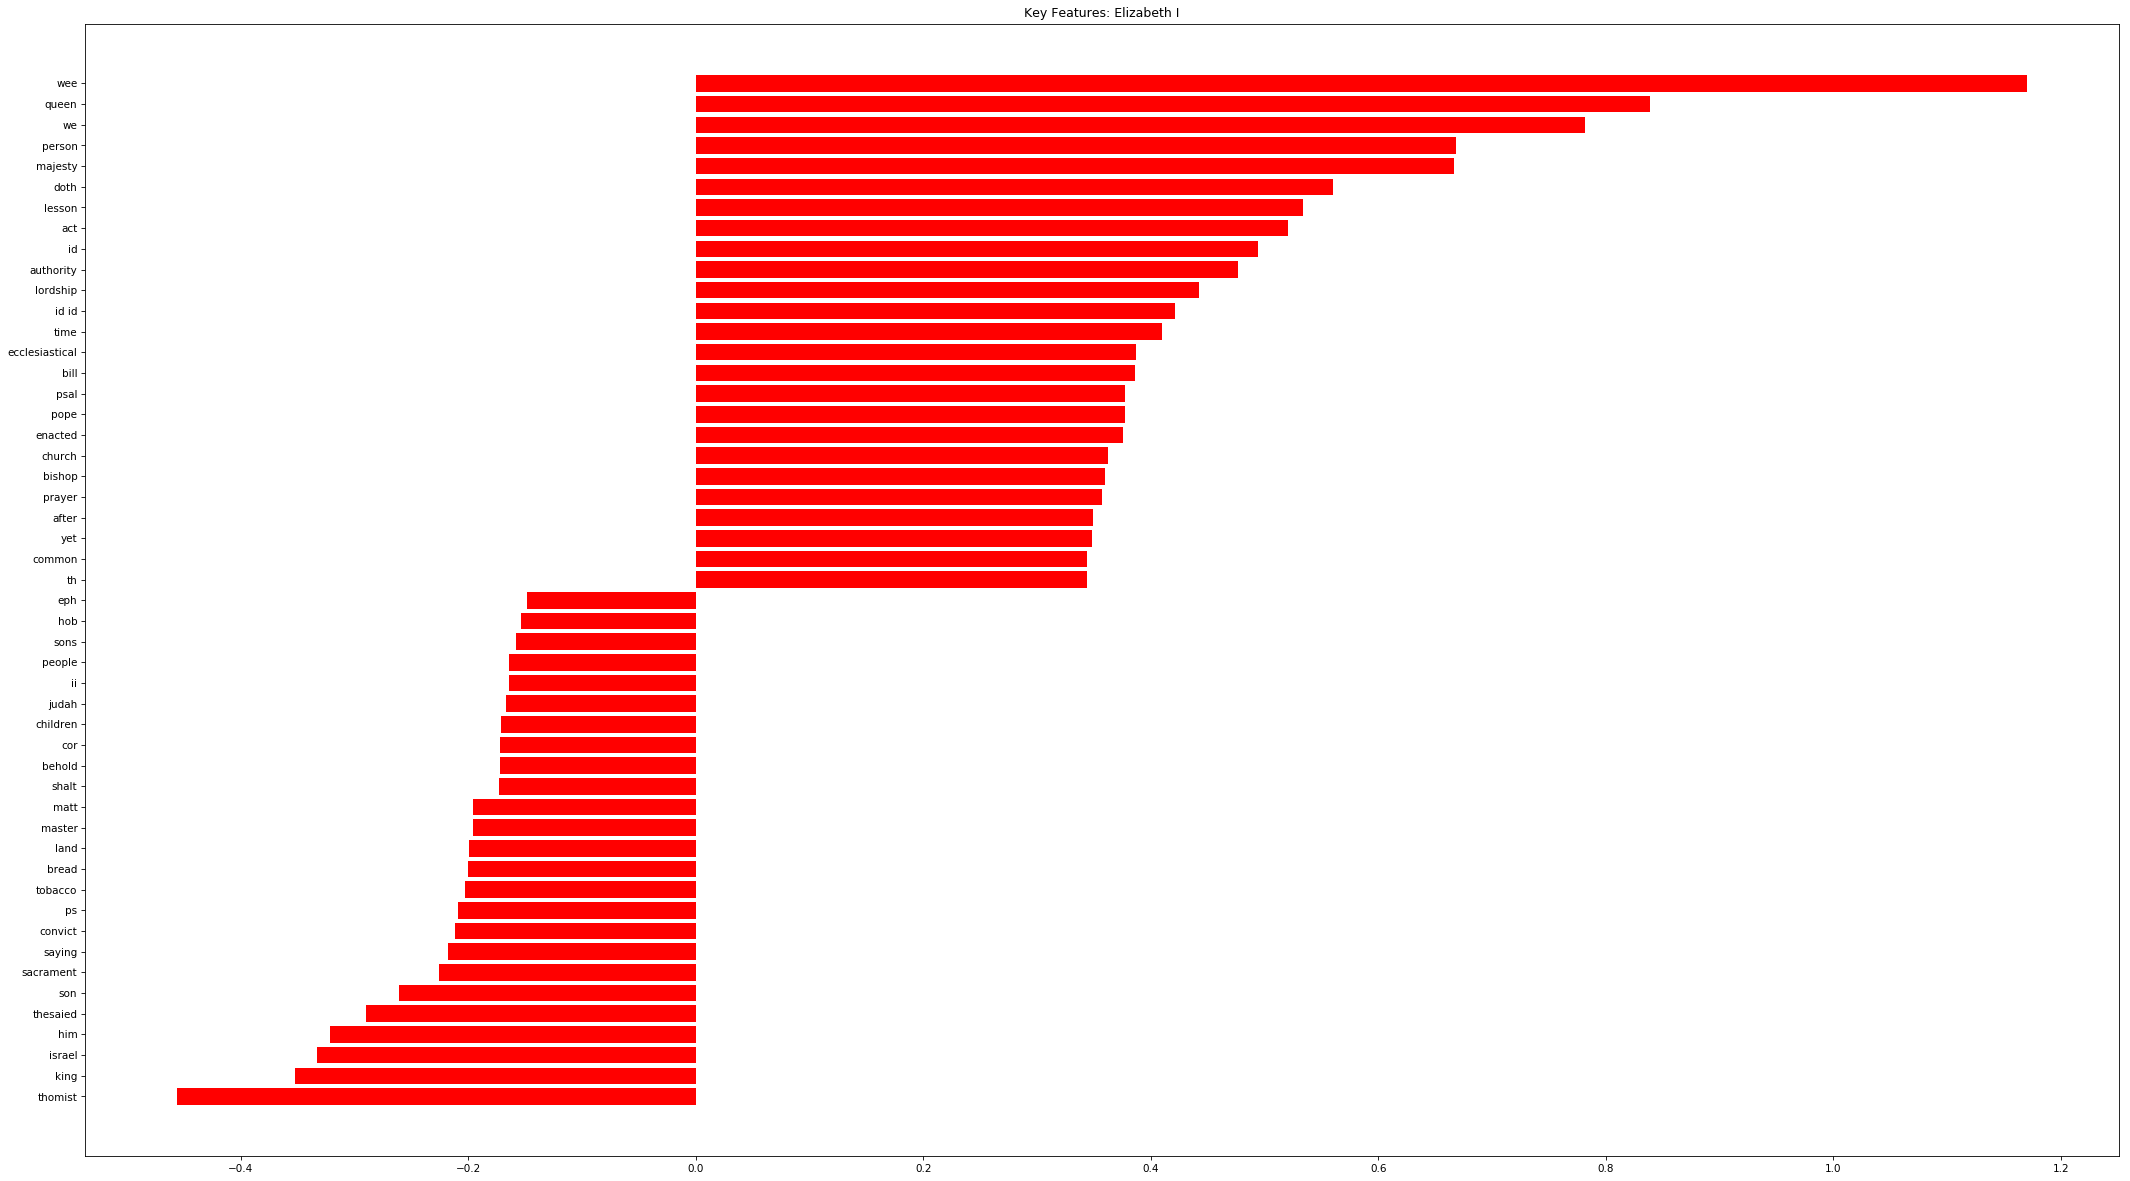

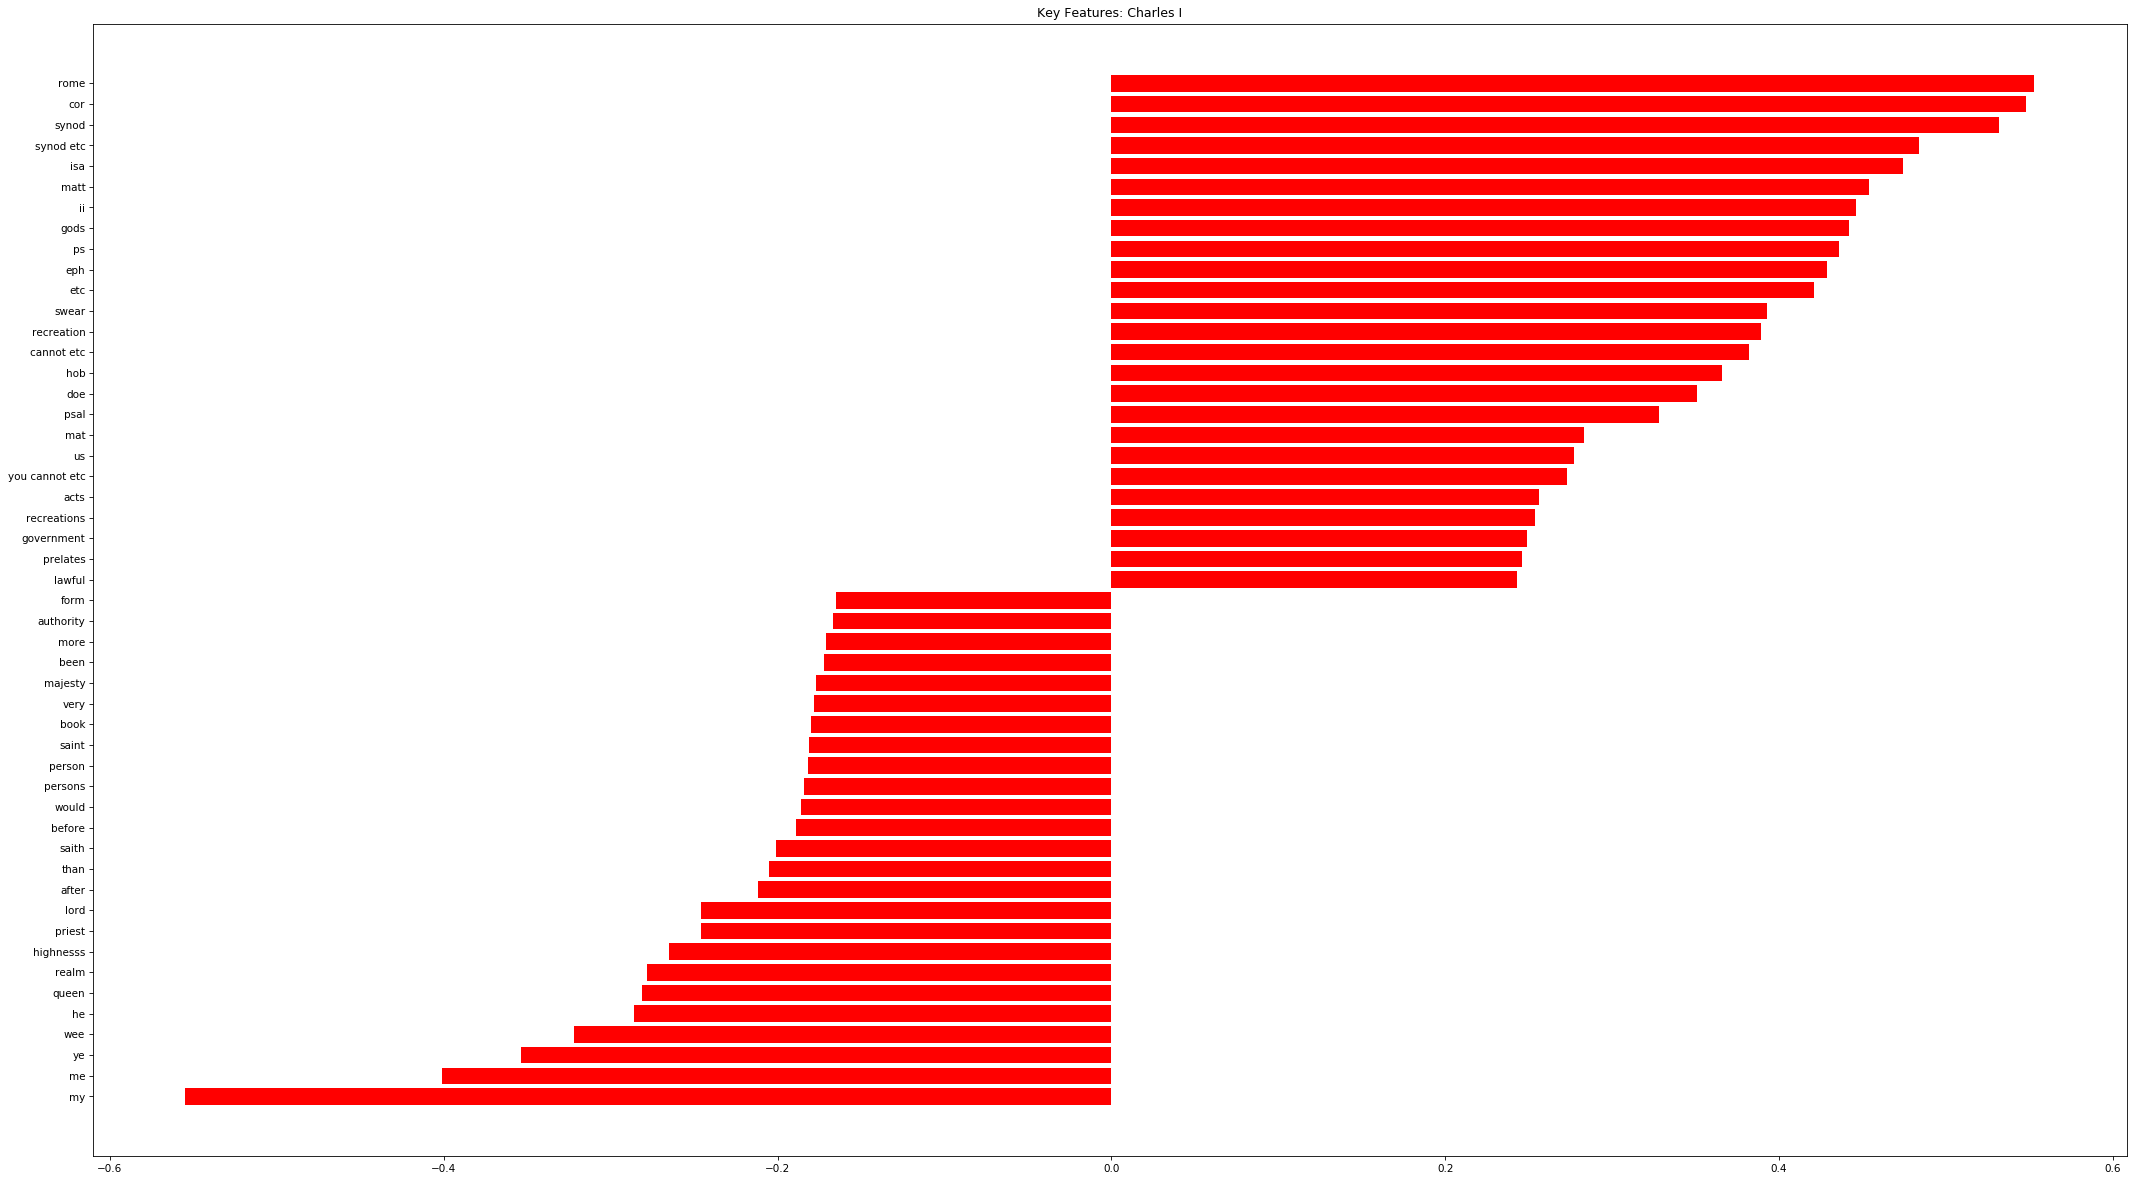

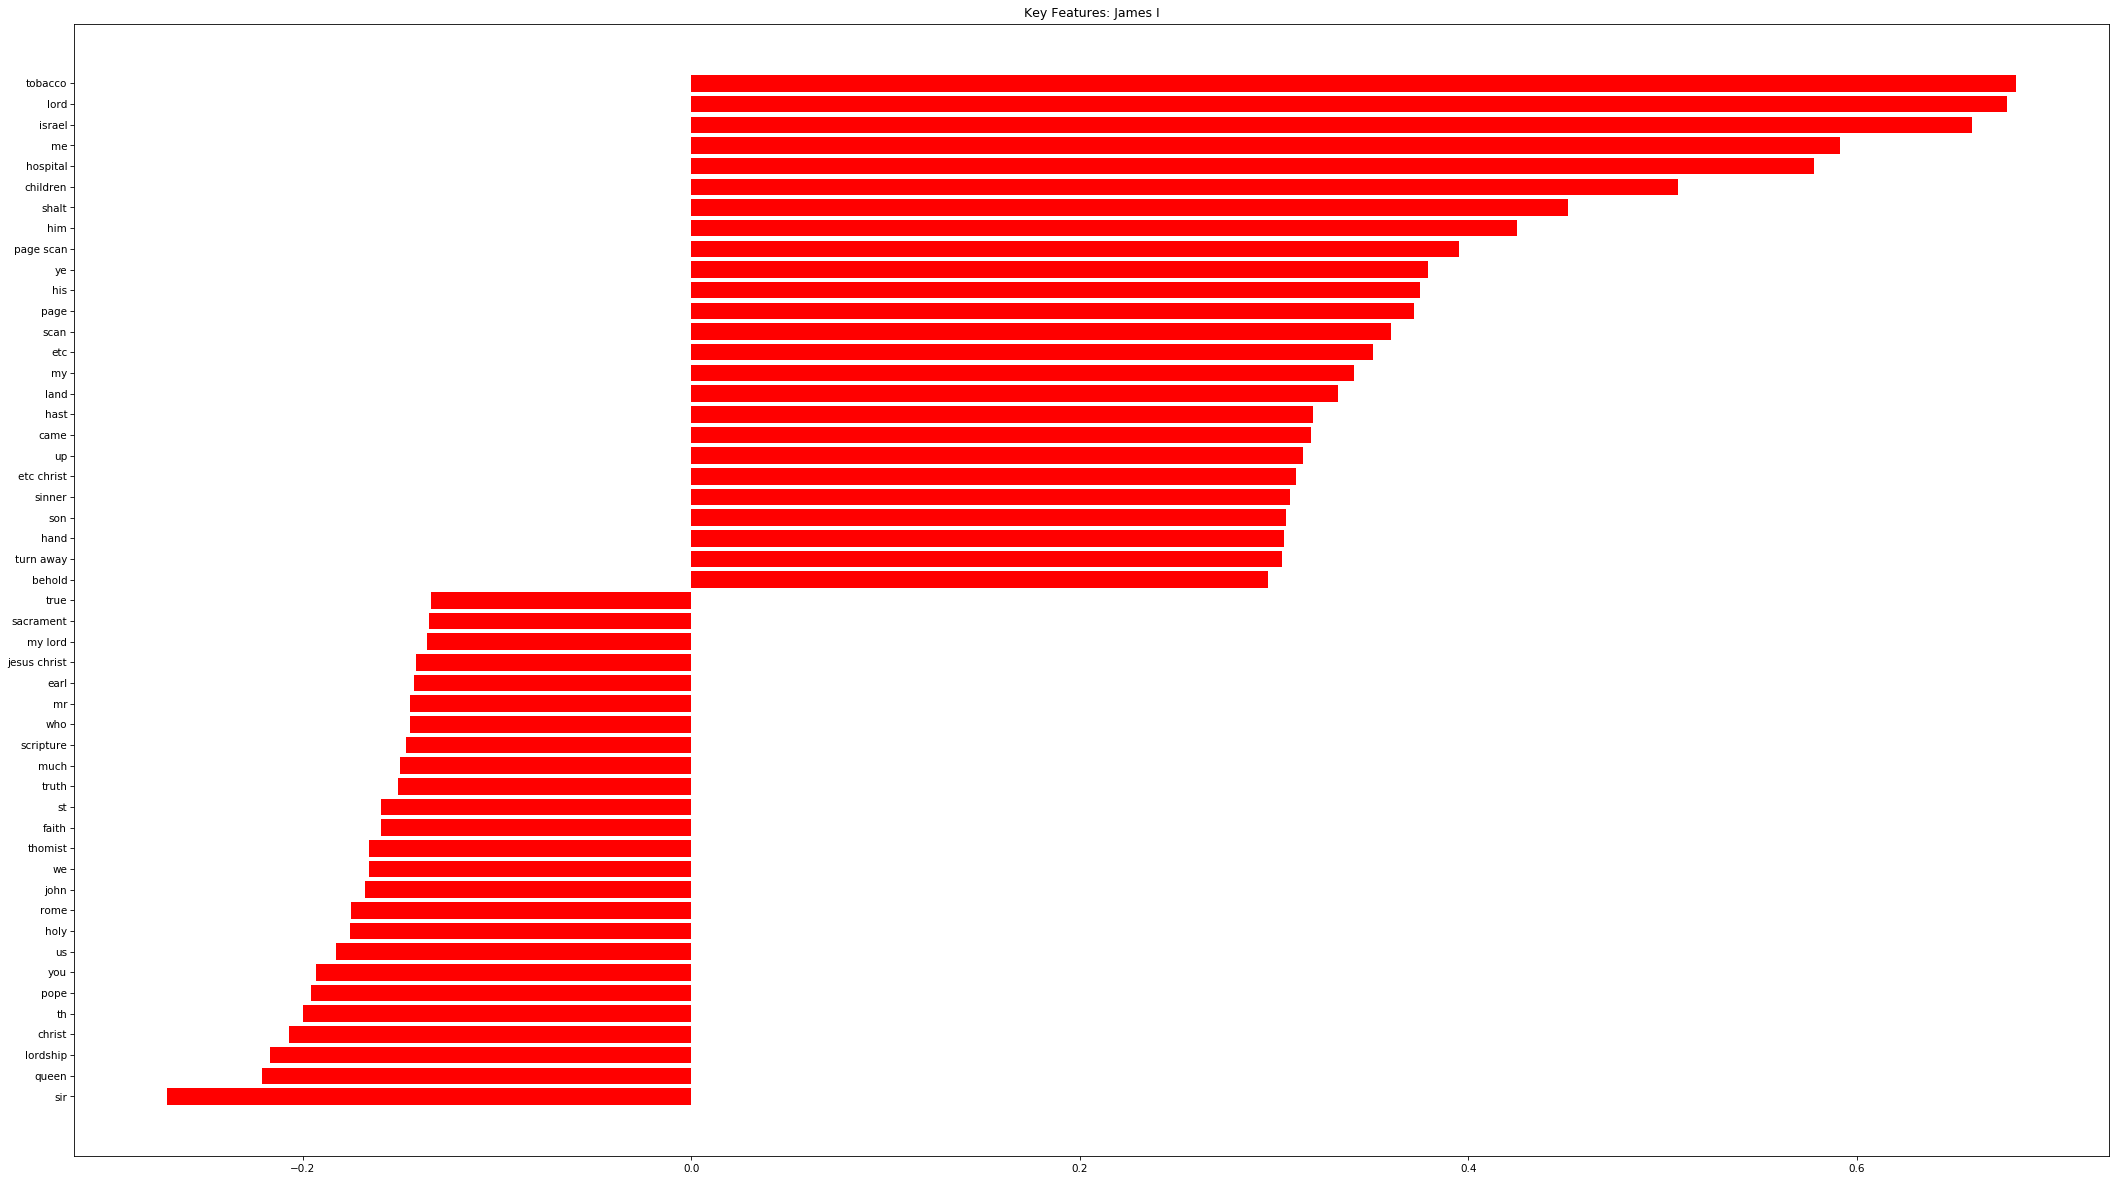

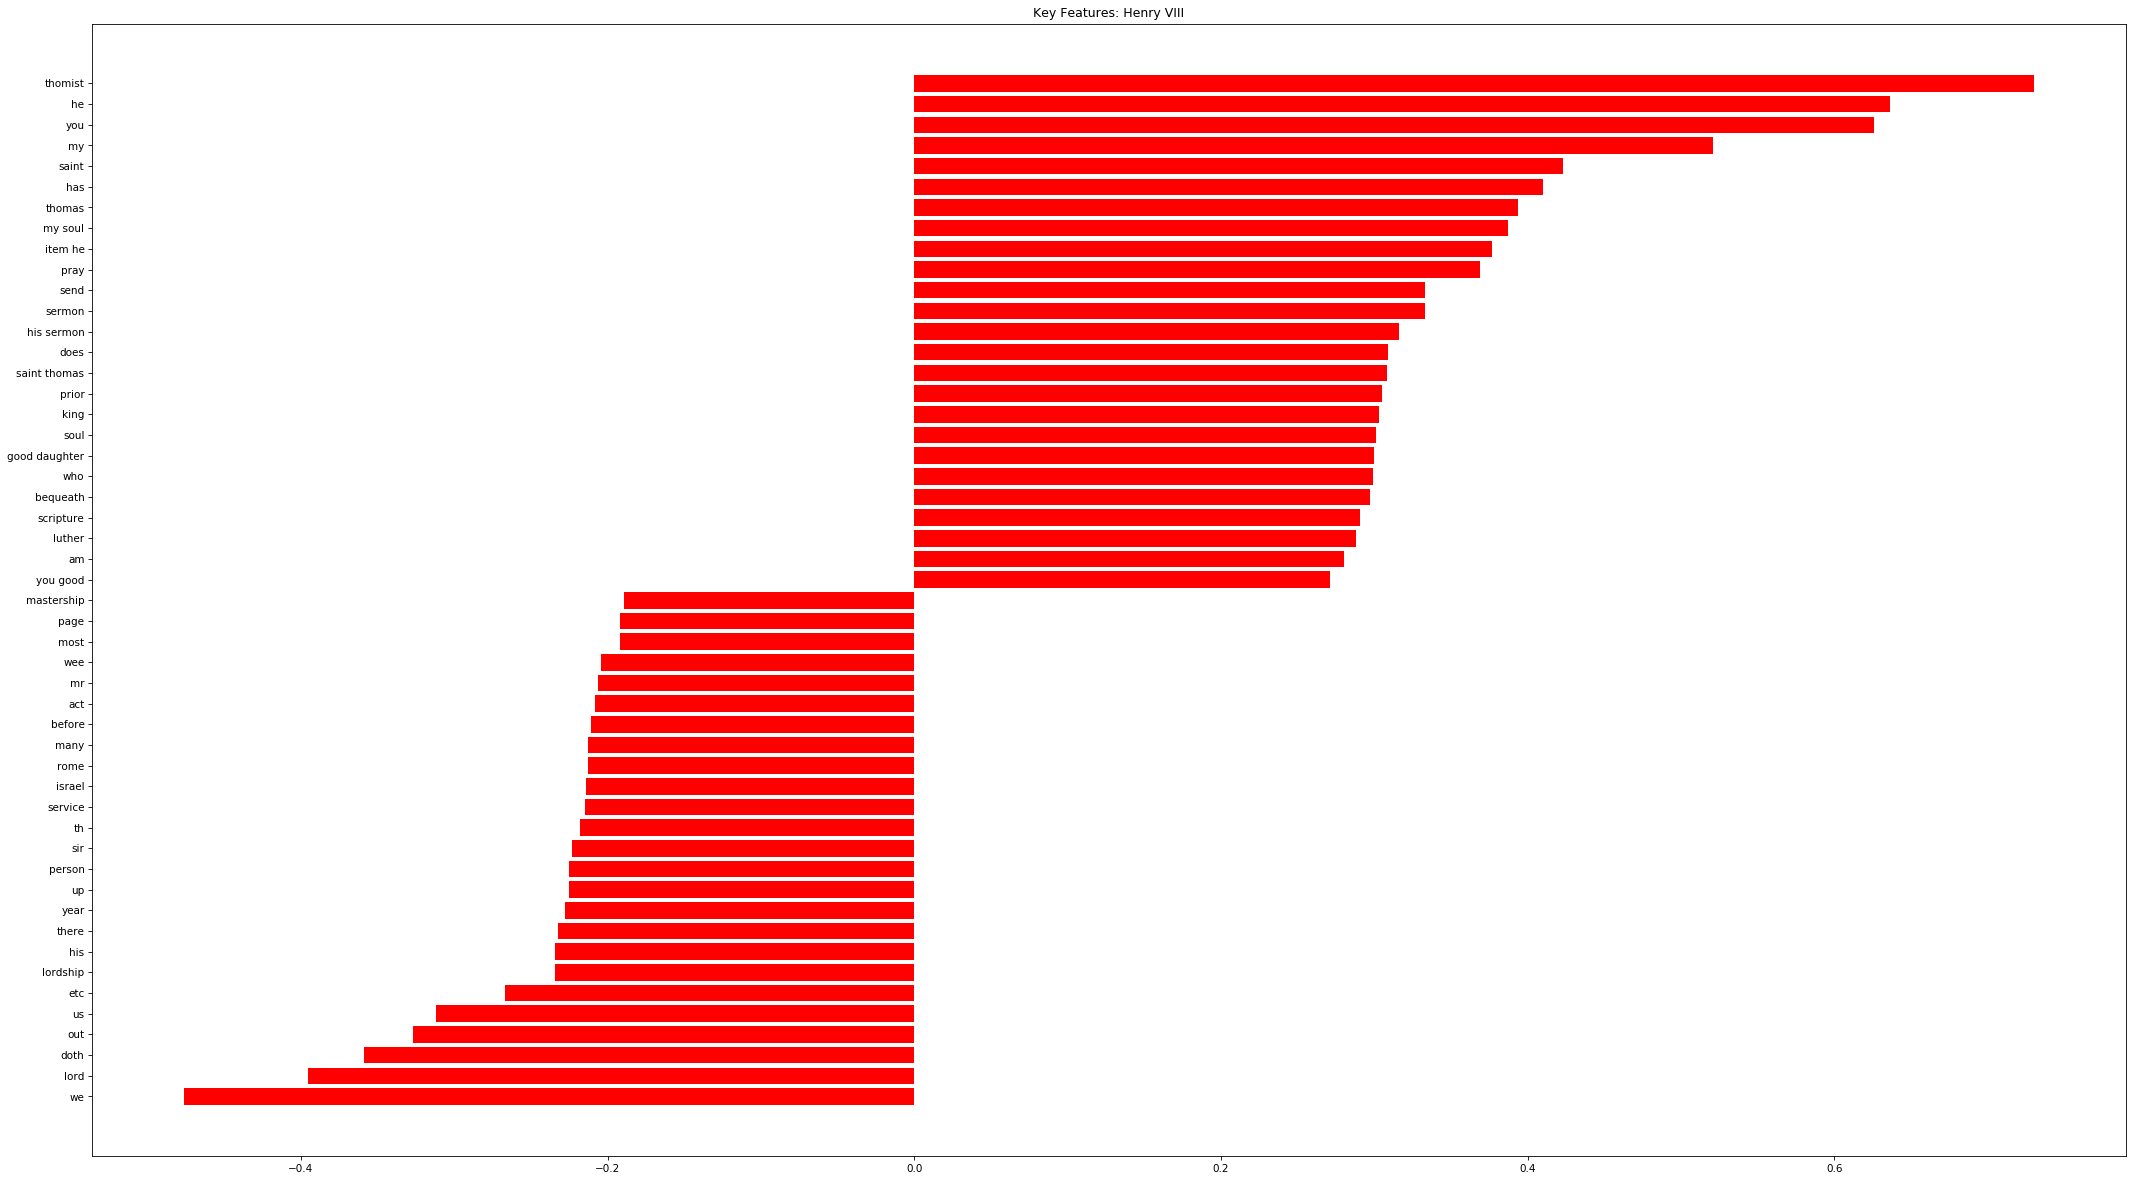

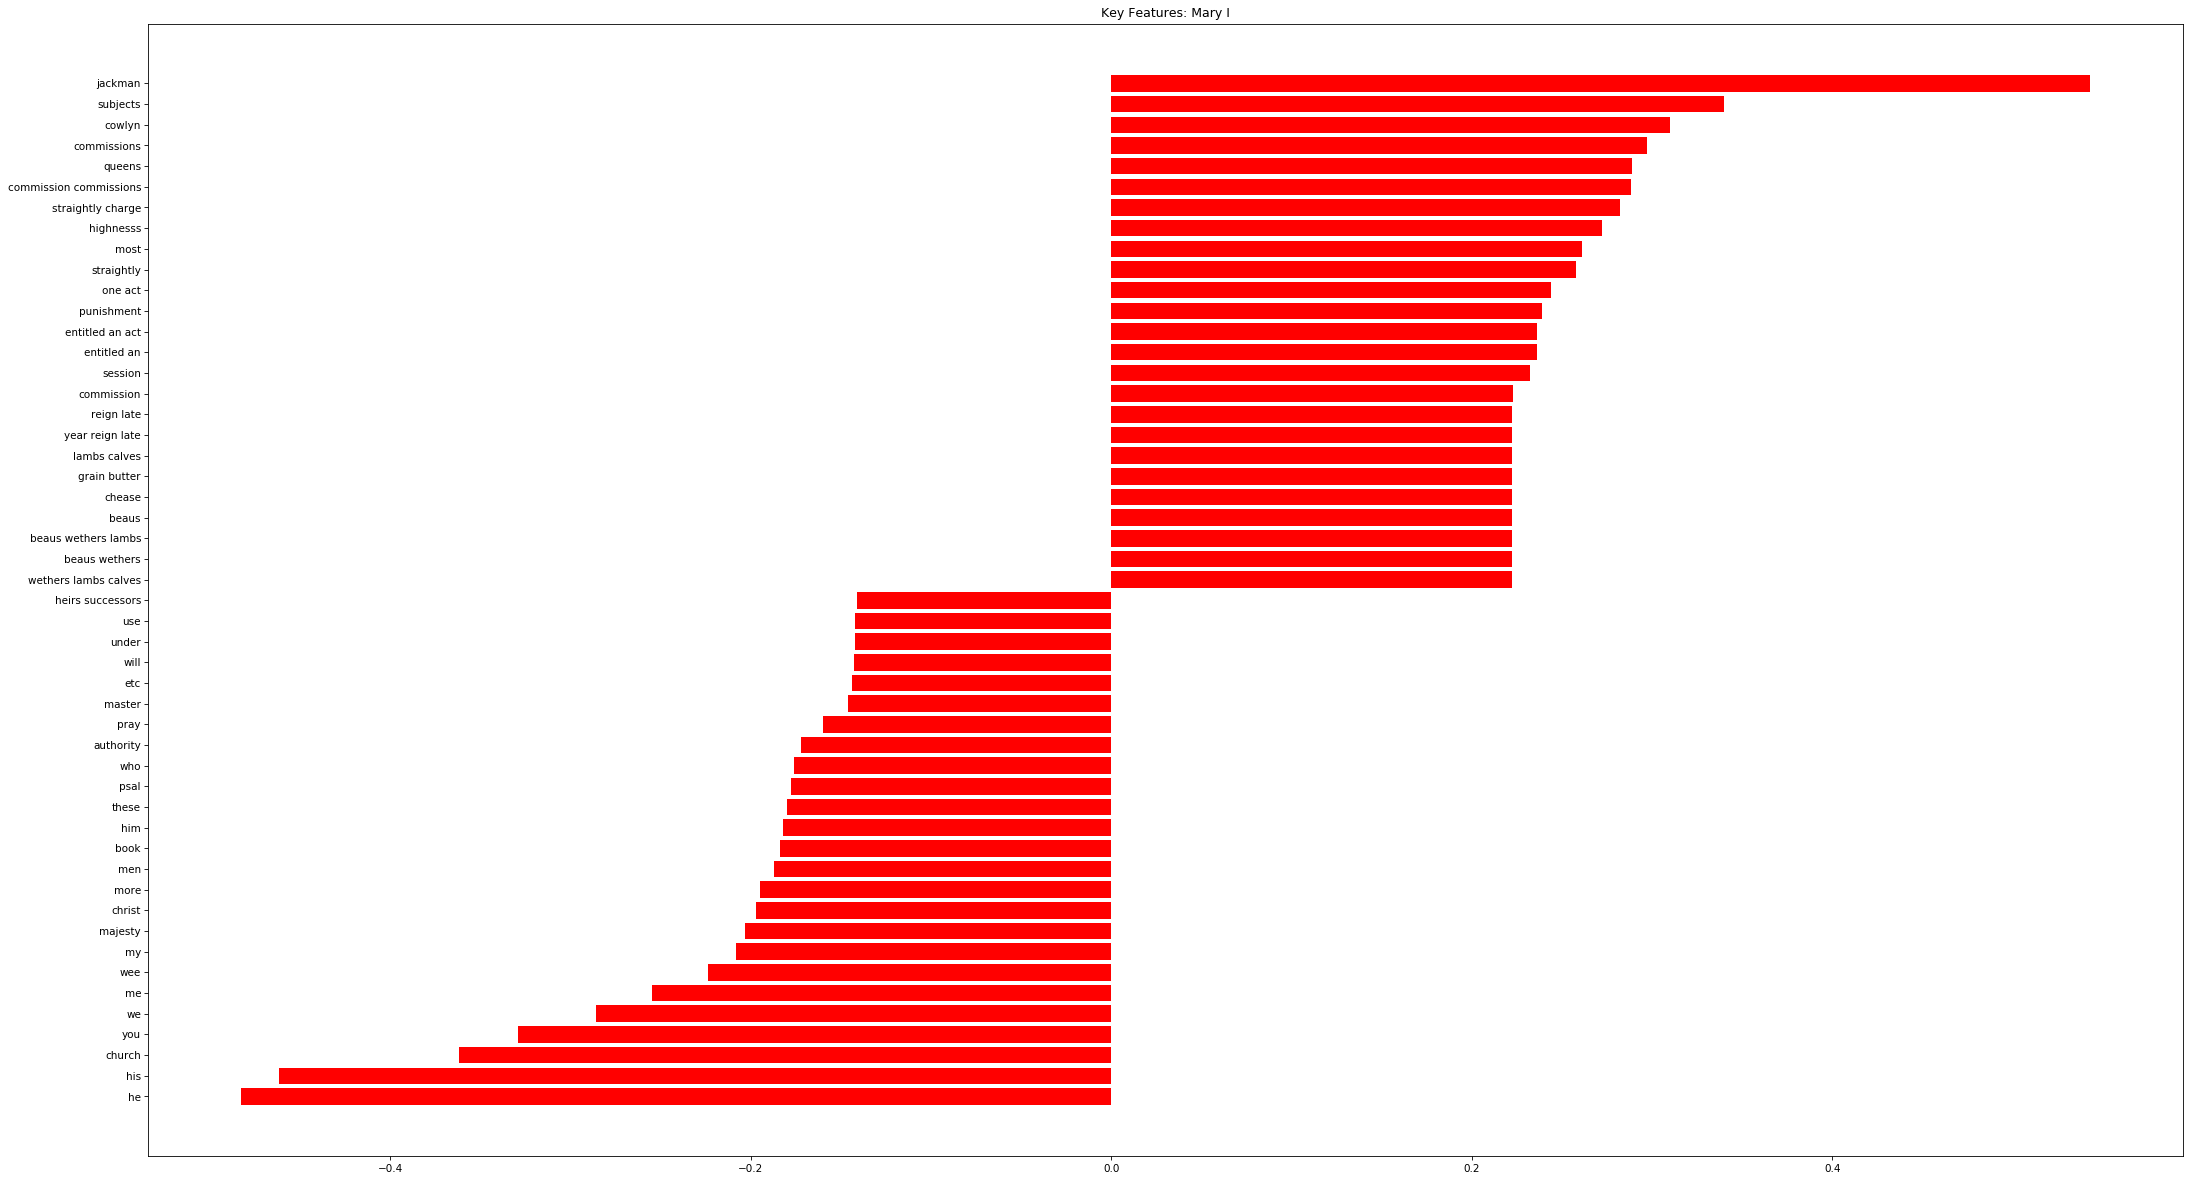

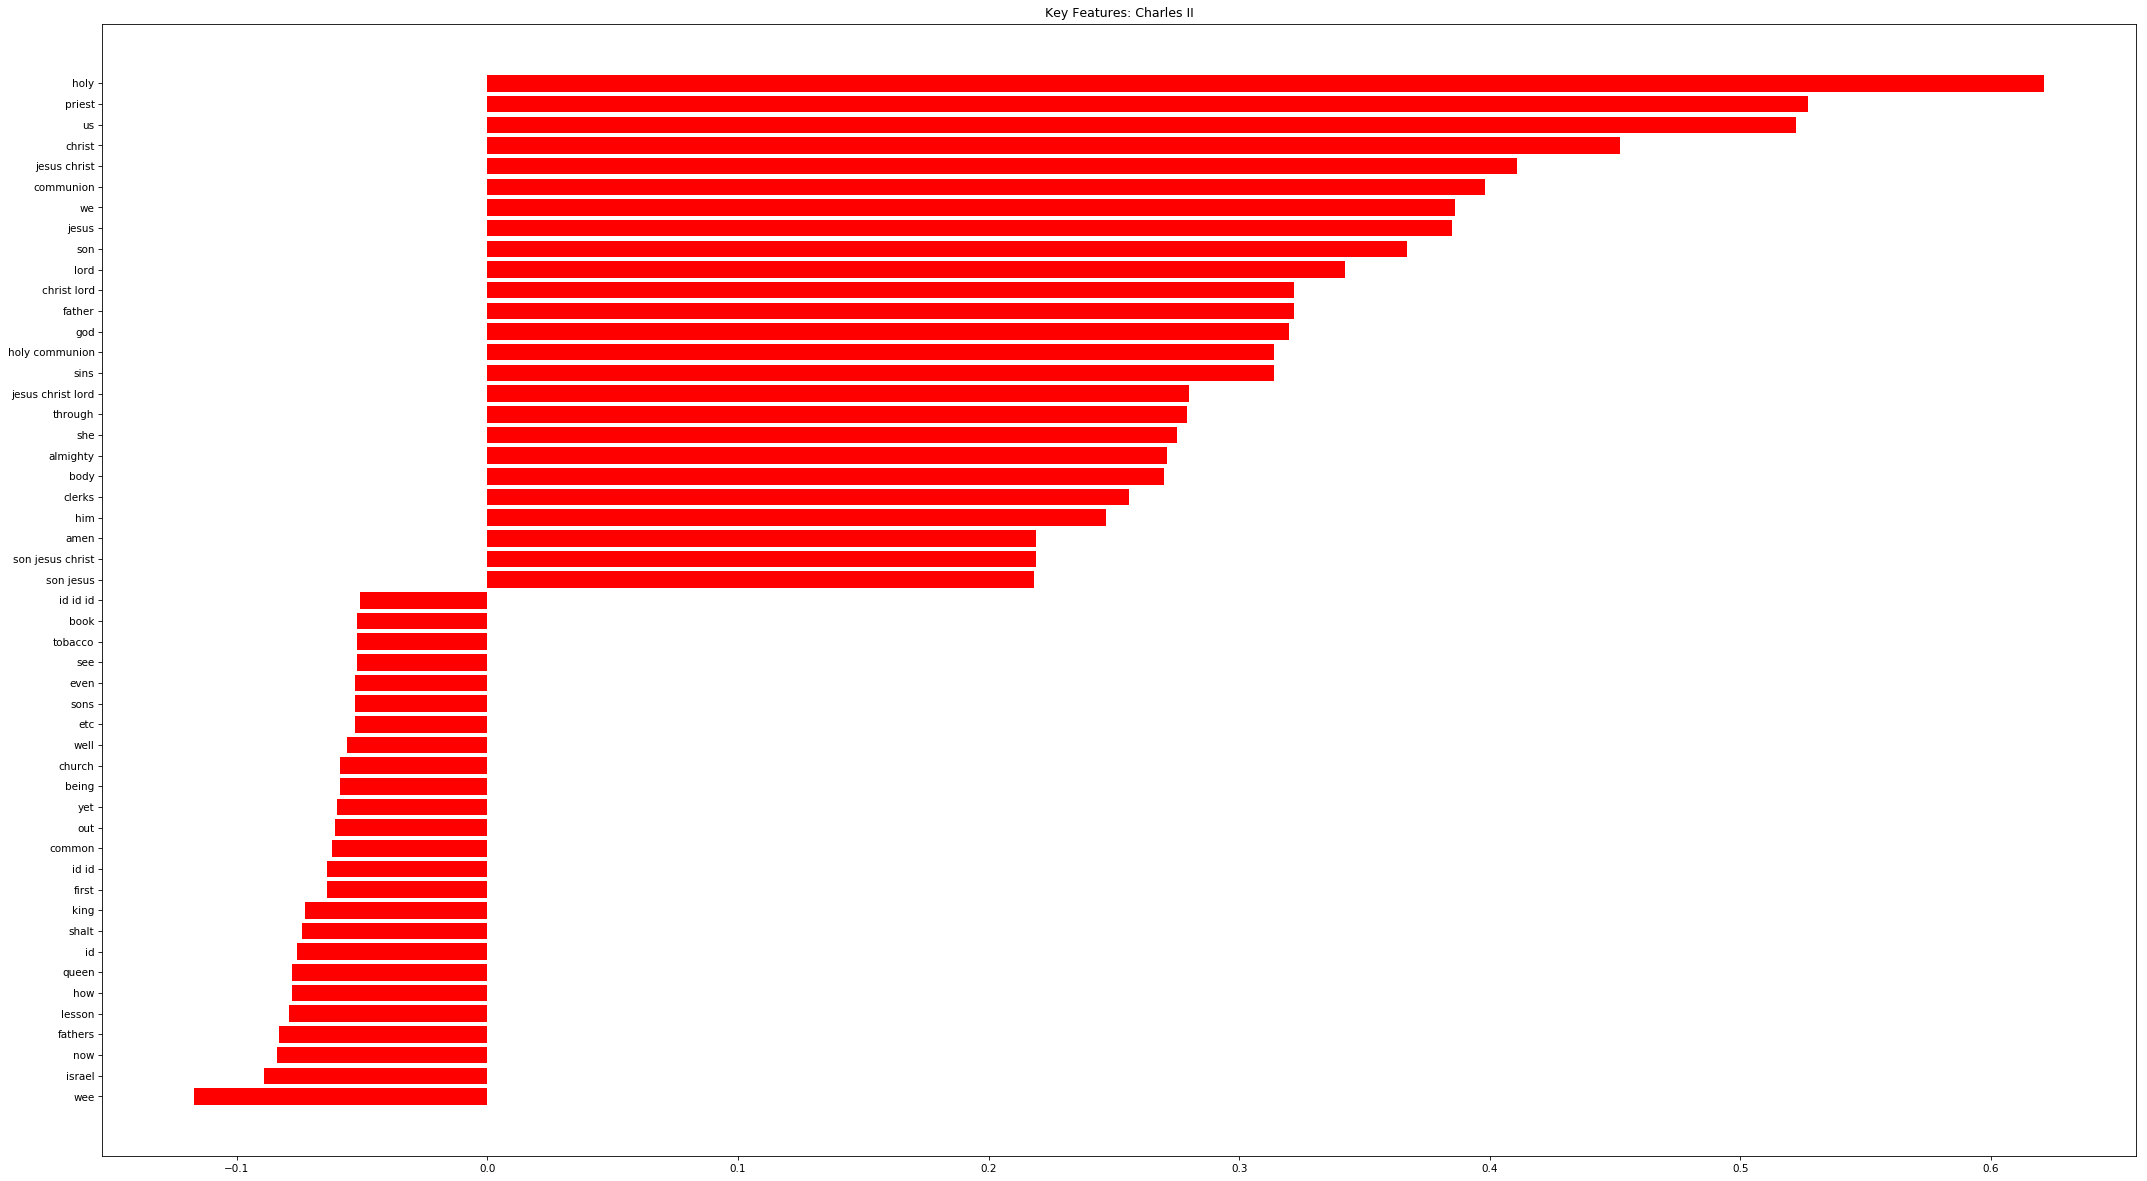

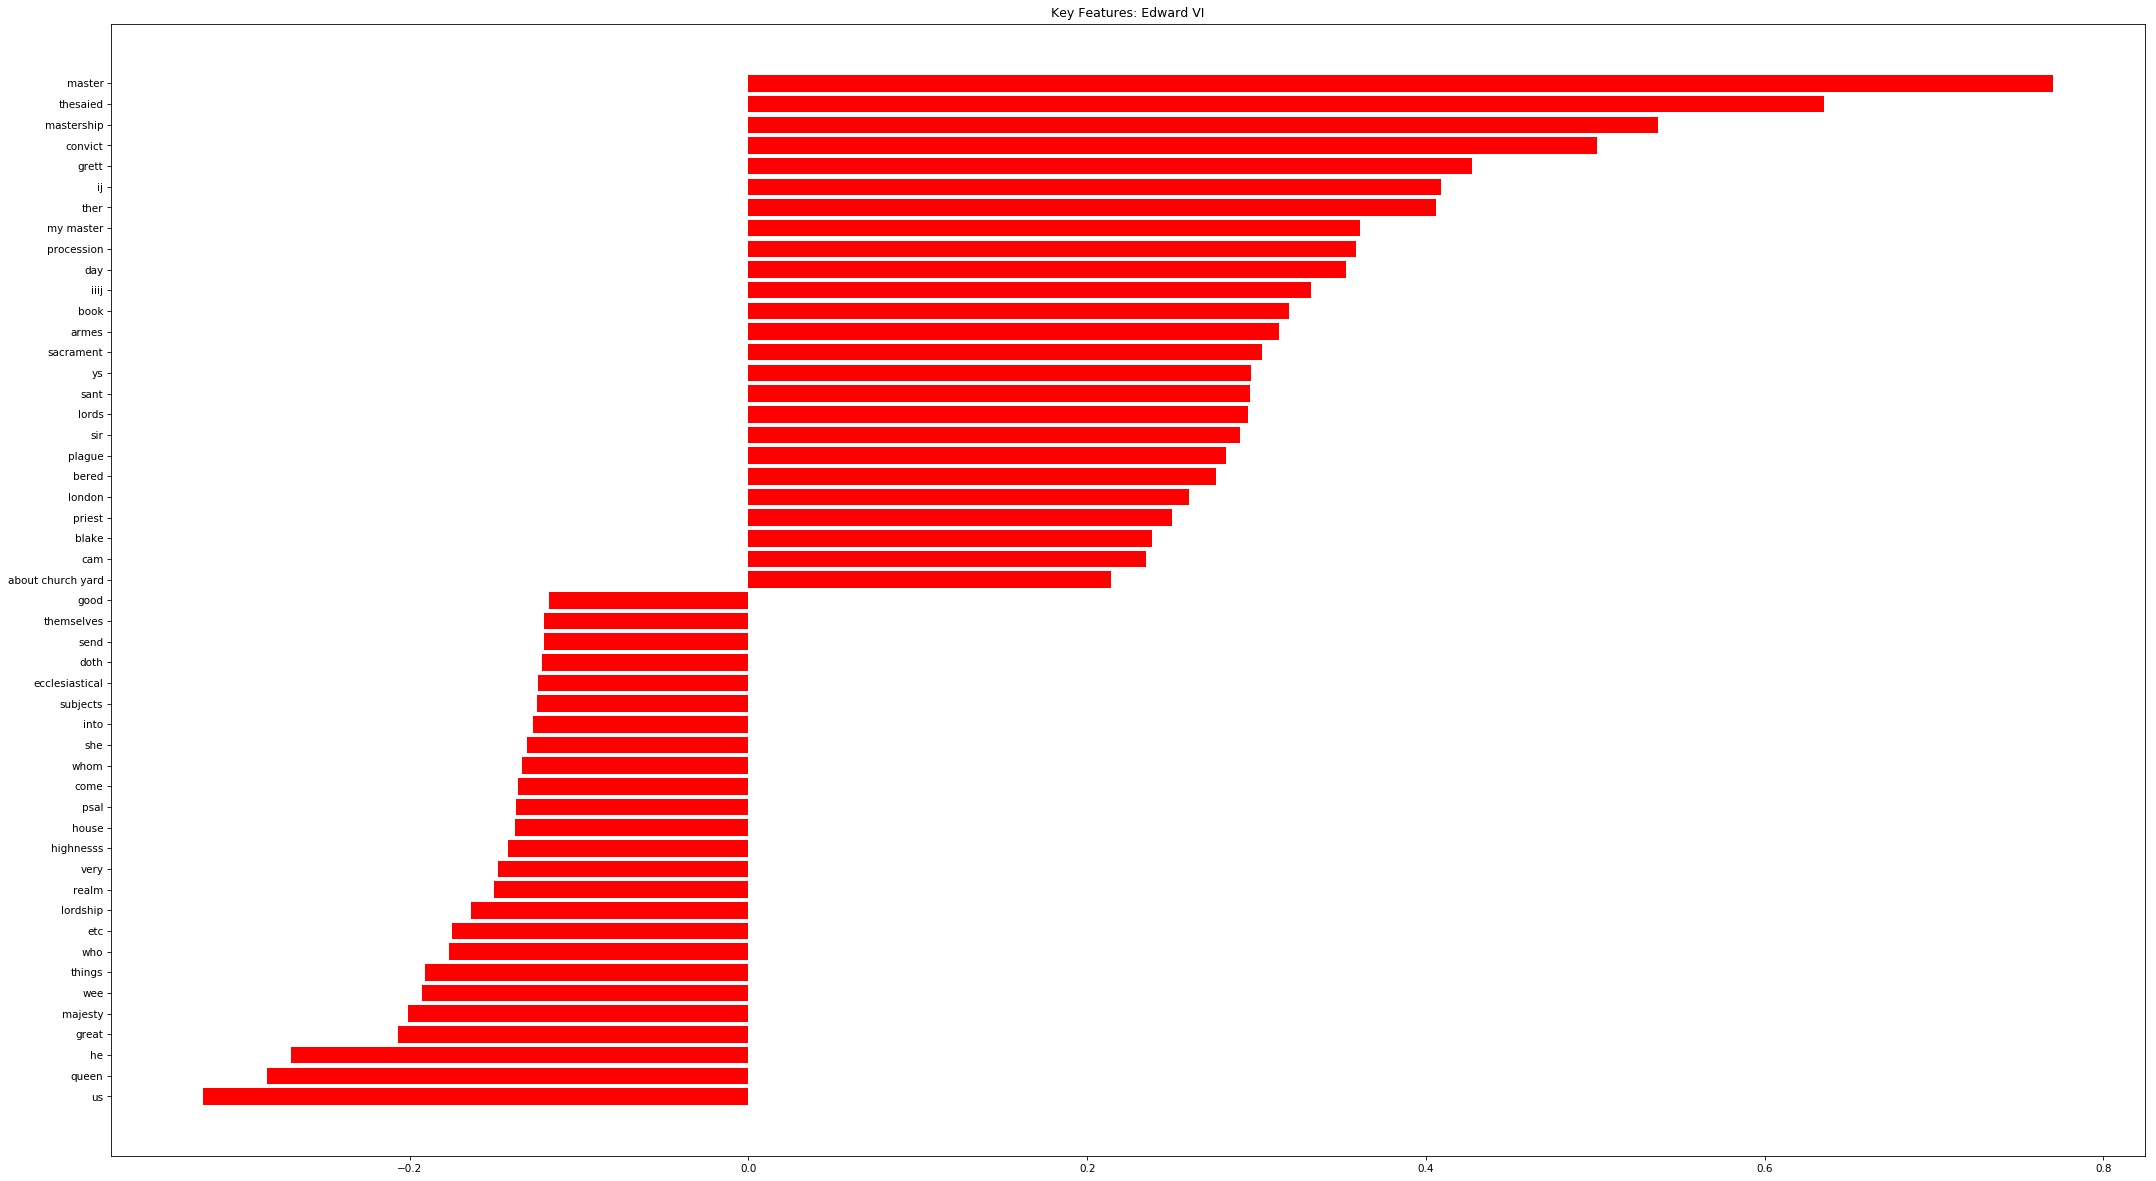

In [10]:
# reduce data
word_cloud_data=dict()
for cl in feature_list.keys():
    viz_words = feature_list[cl][:25] + feature_list[cl][-25:]
    word_cloud_data[cl] = dict()
    for i in feature_list[cl][:100]:
        word_cloud_data[cl][i[0]] = float(i[1])
        
    values = [x[1] for x in viz_words]
    kwords = [x[0] for x in viz_words]
    y_pos = range(len(values))

    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(35, 20), dpi=75)
    plt.barh(y_pos, values, align='center',tick_label=kwords,color="red")
    plt.title("Key Features: {0}".format(cl))
    plt.show()

Class: Elizabeth I


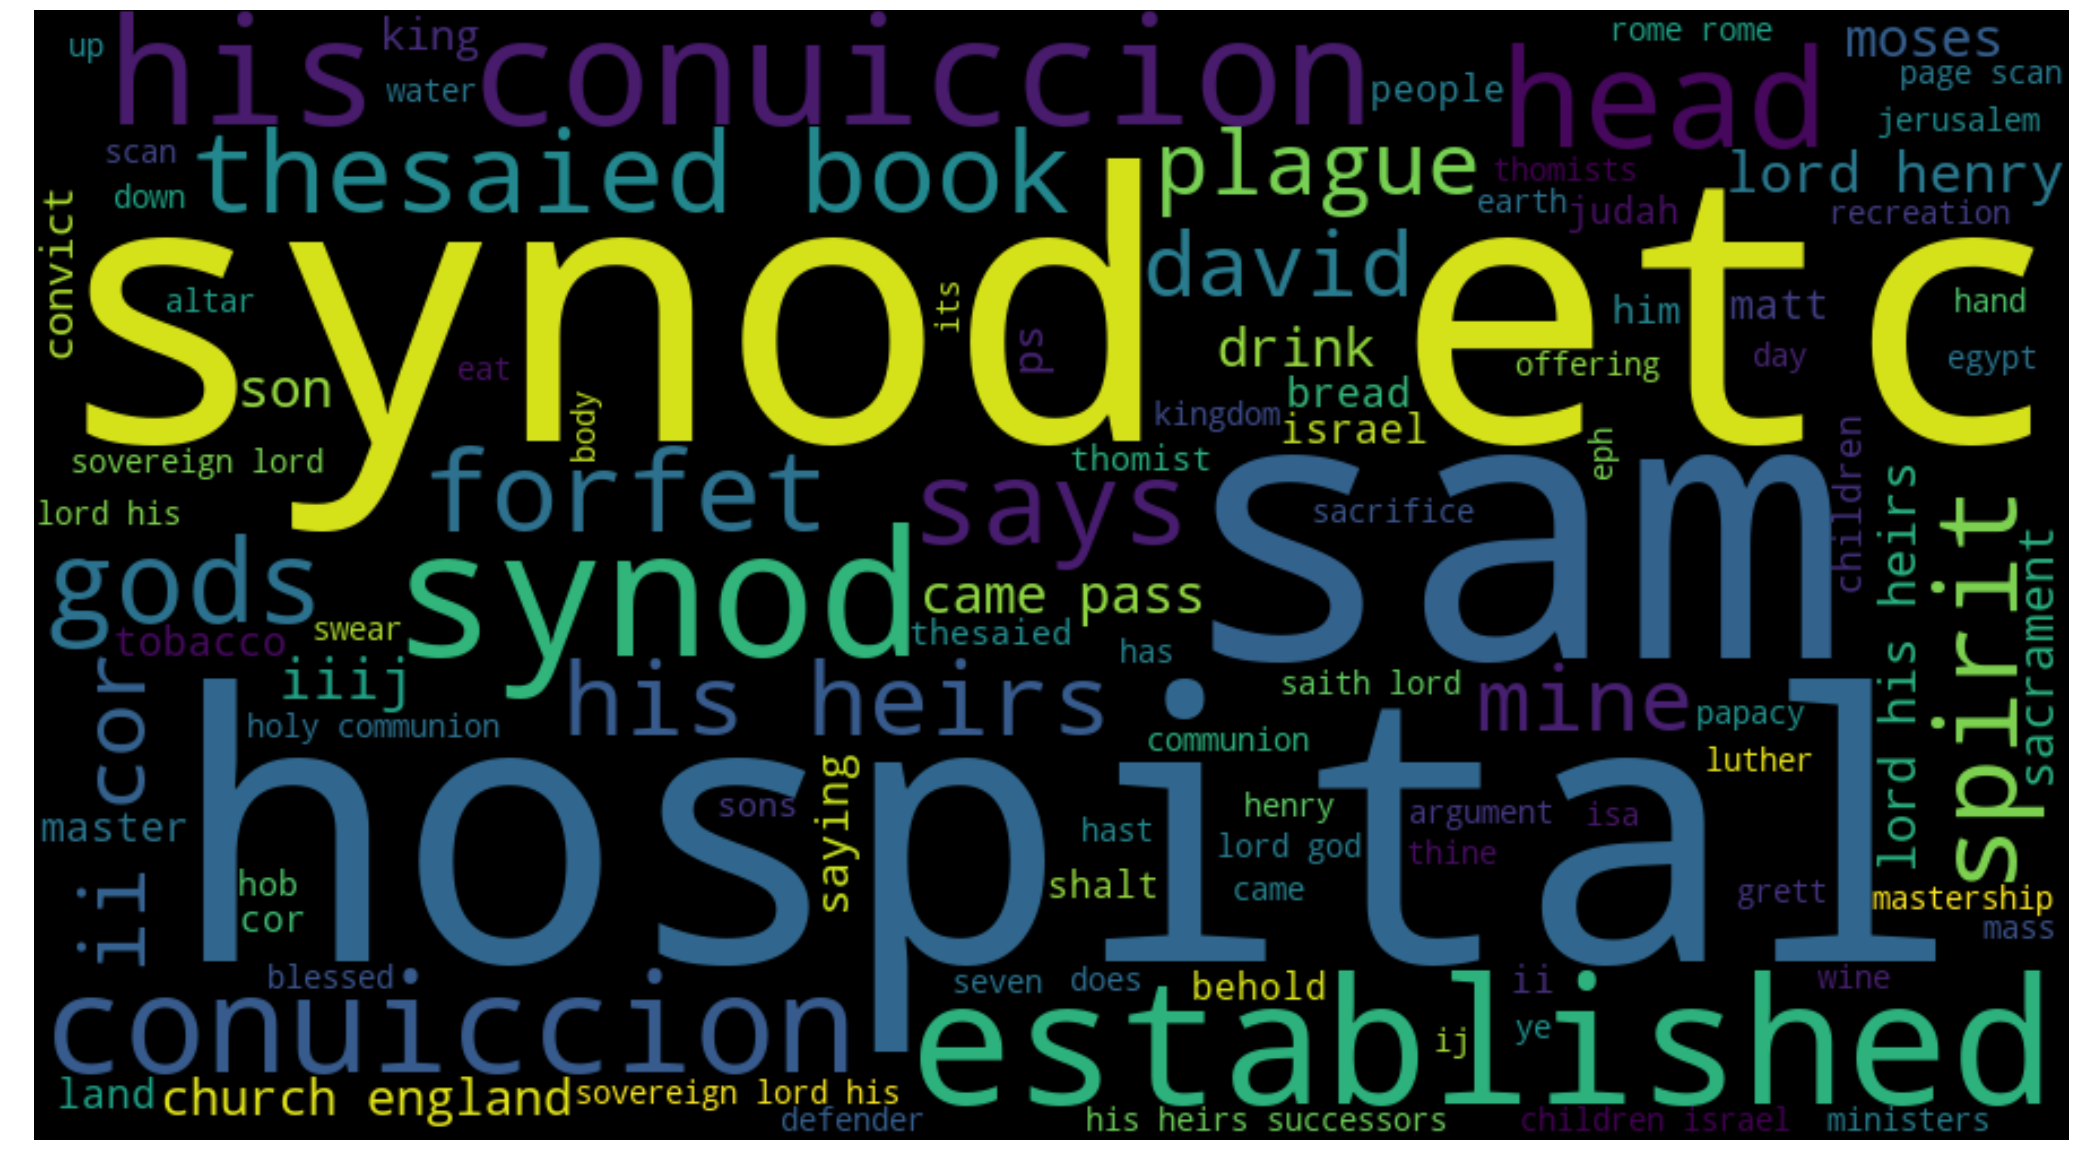

Class: Henry VIII


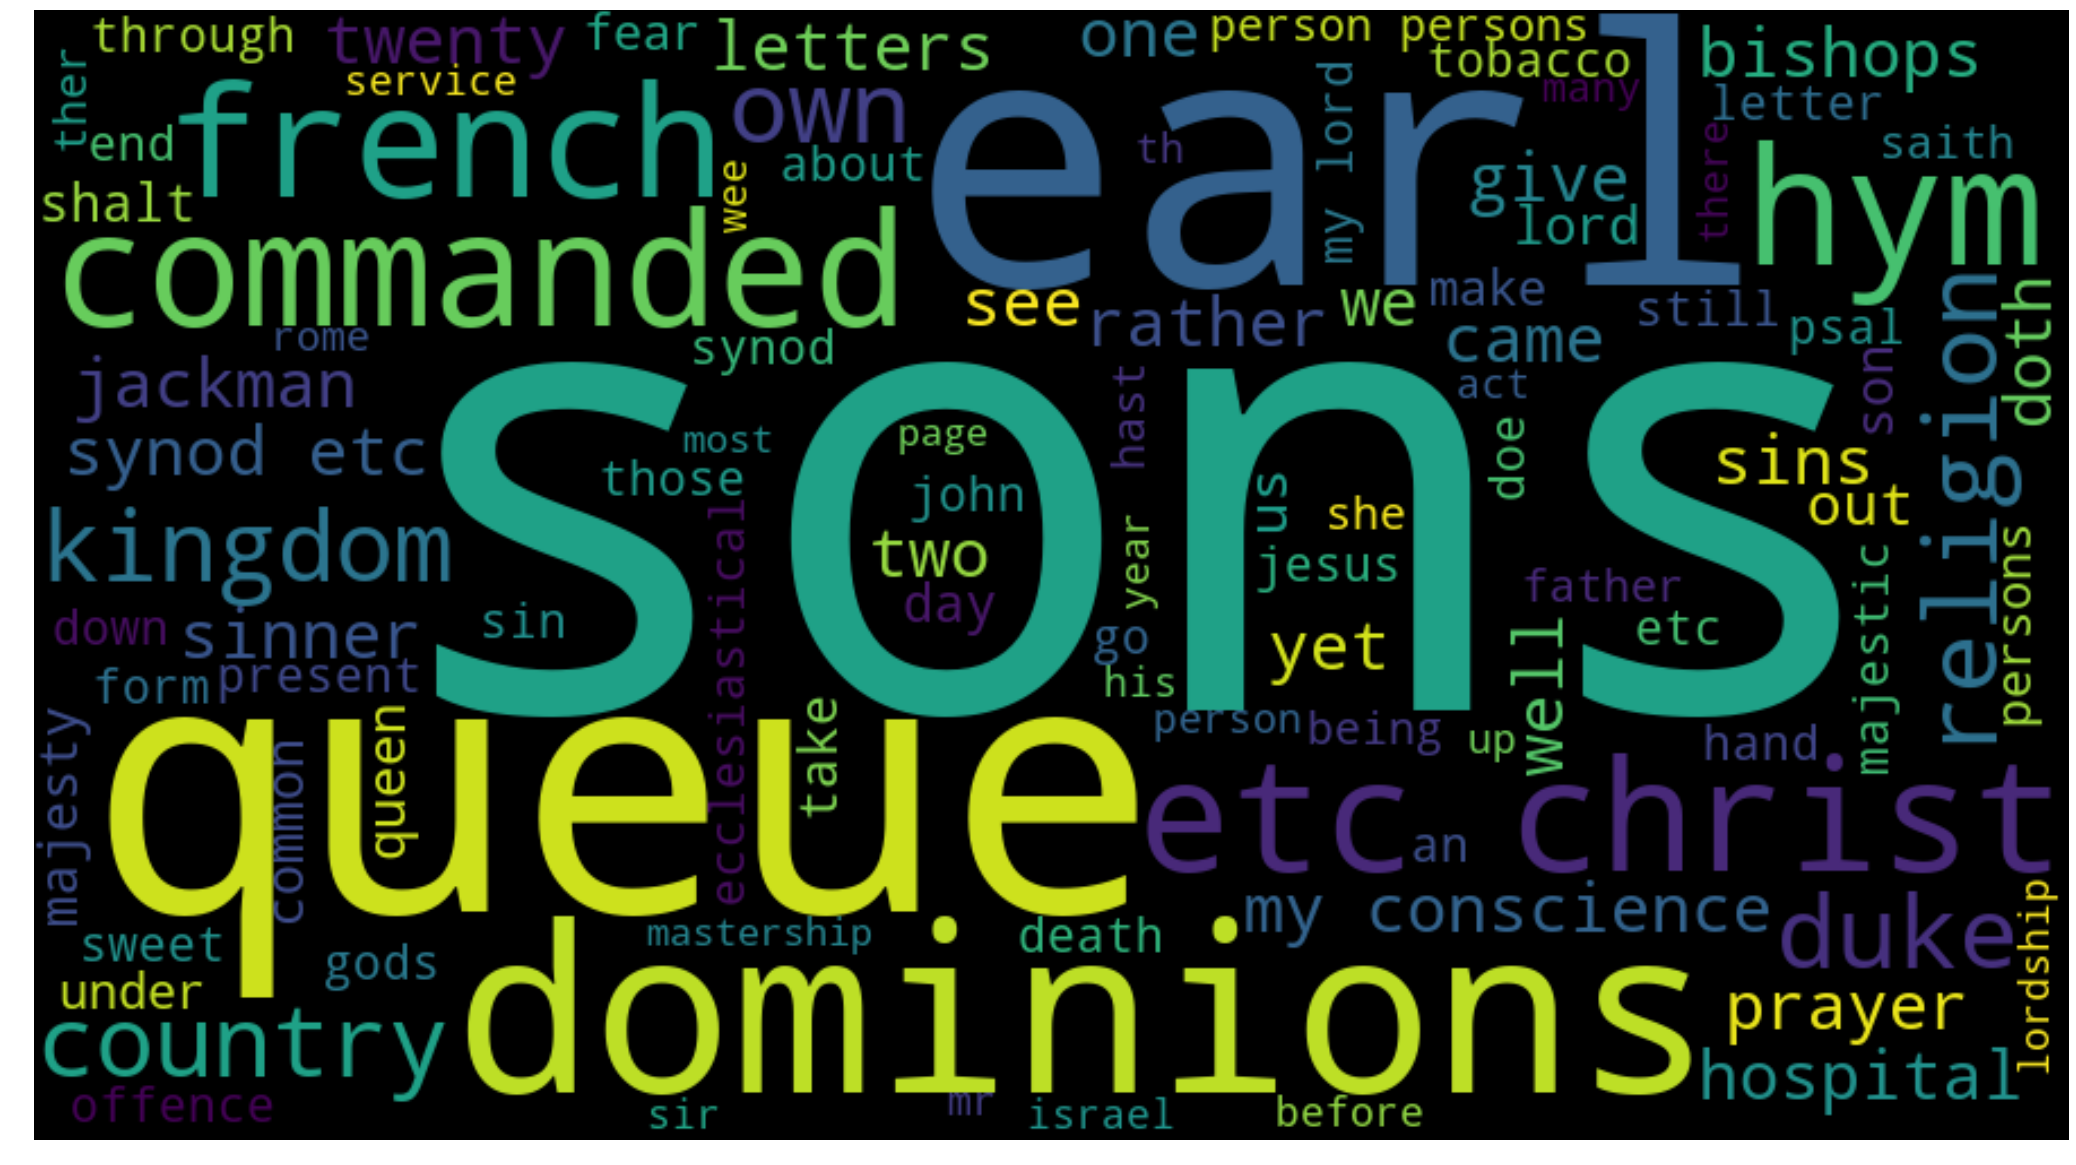

Class: Mary I


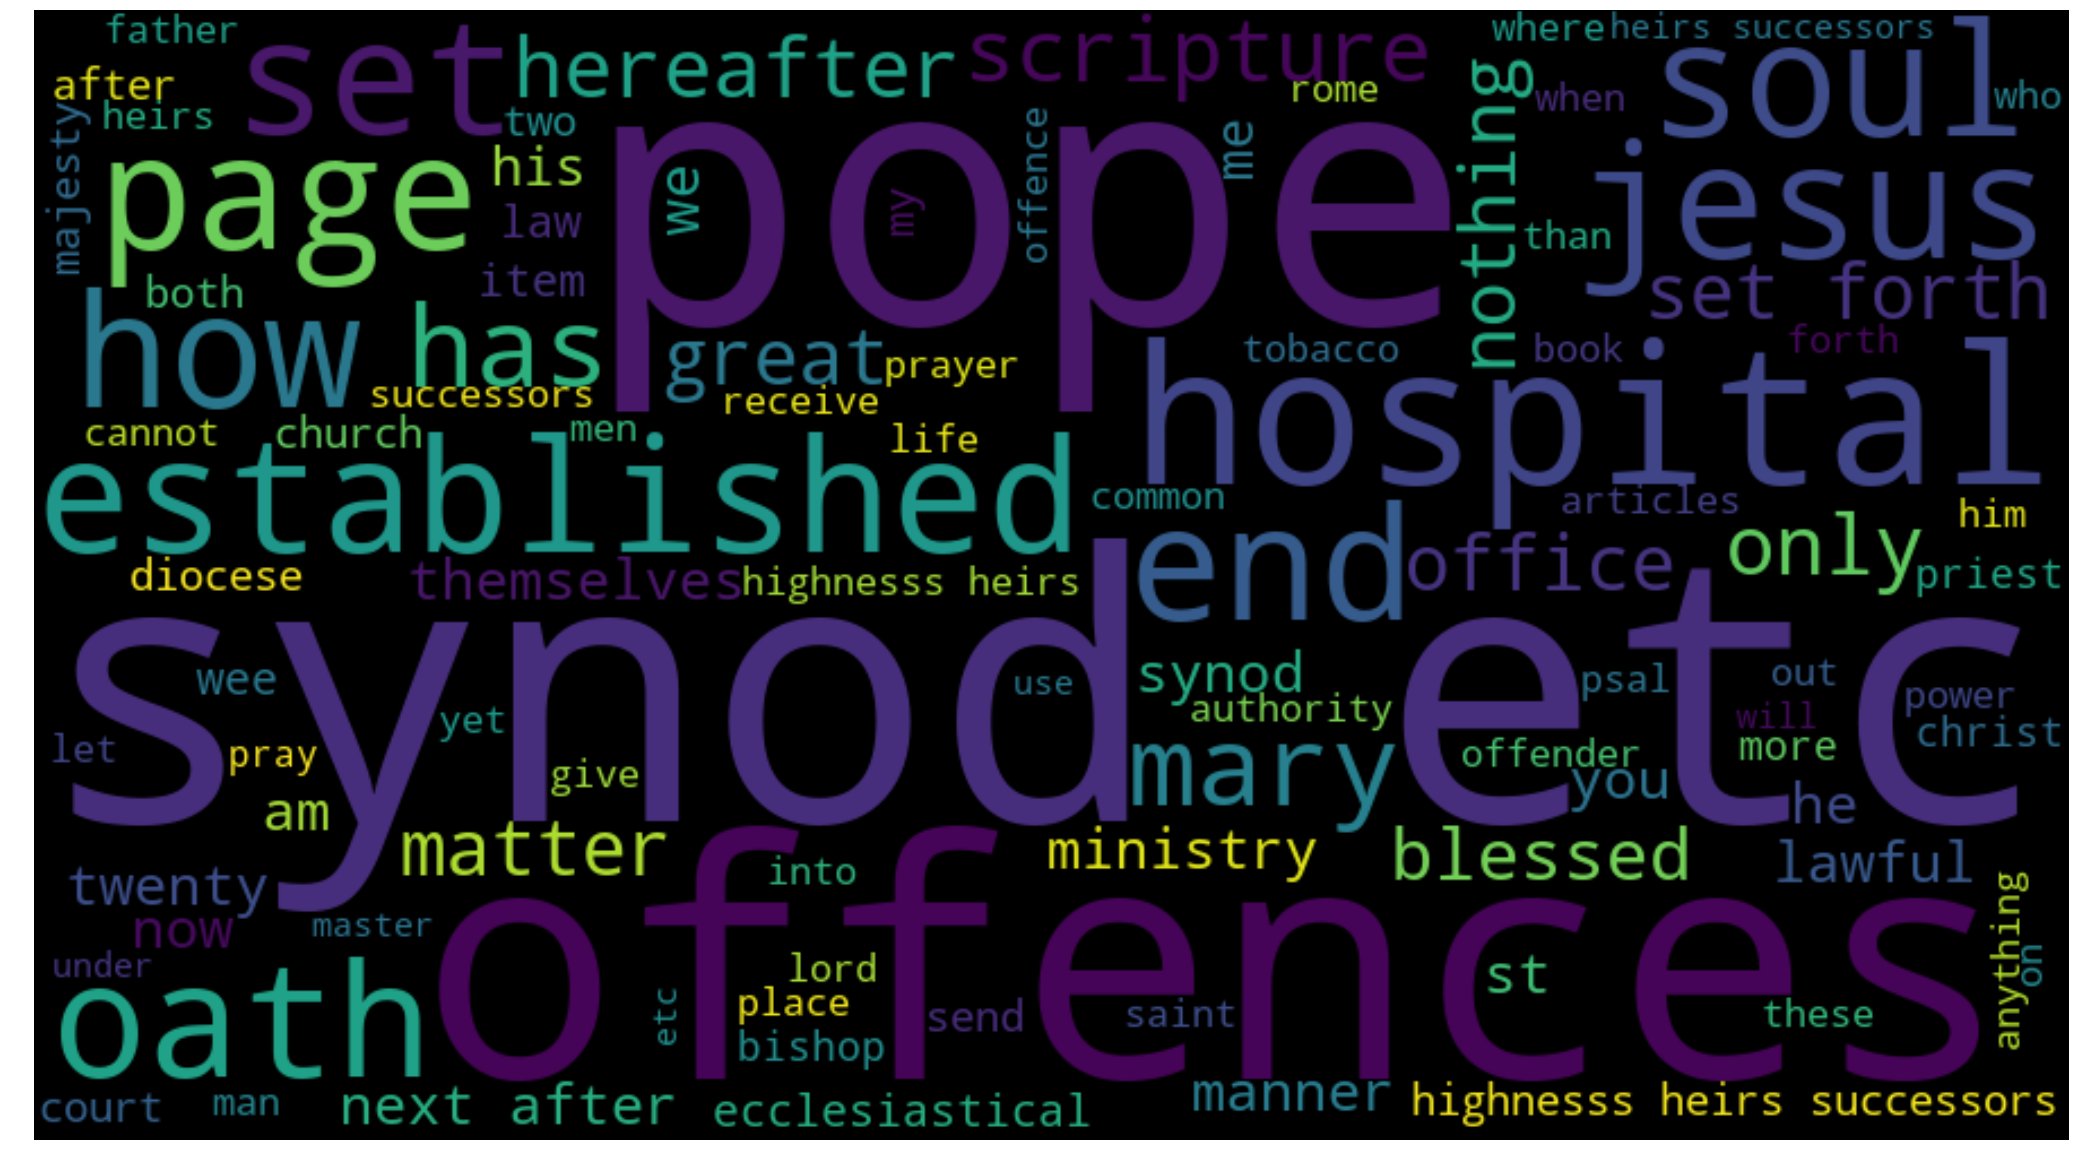

Class: Charles II


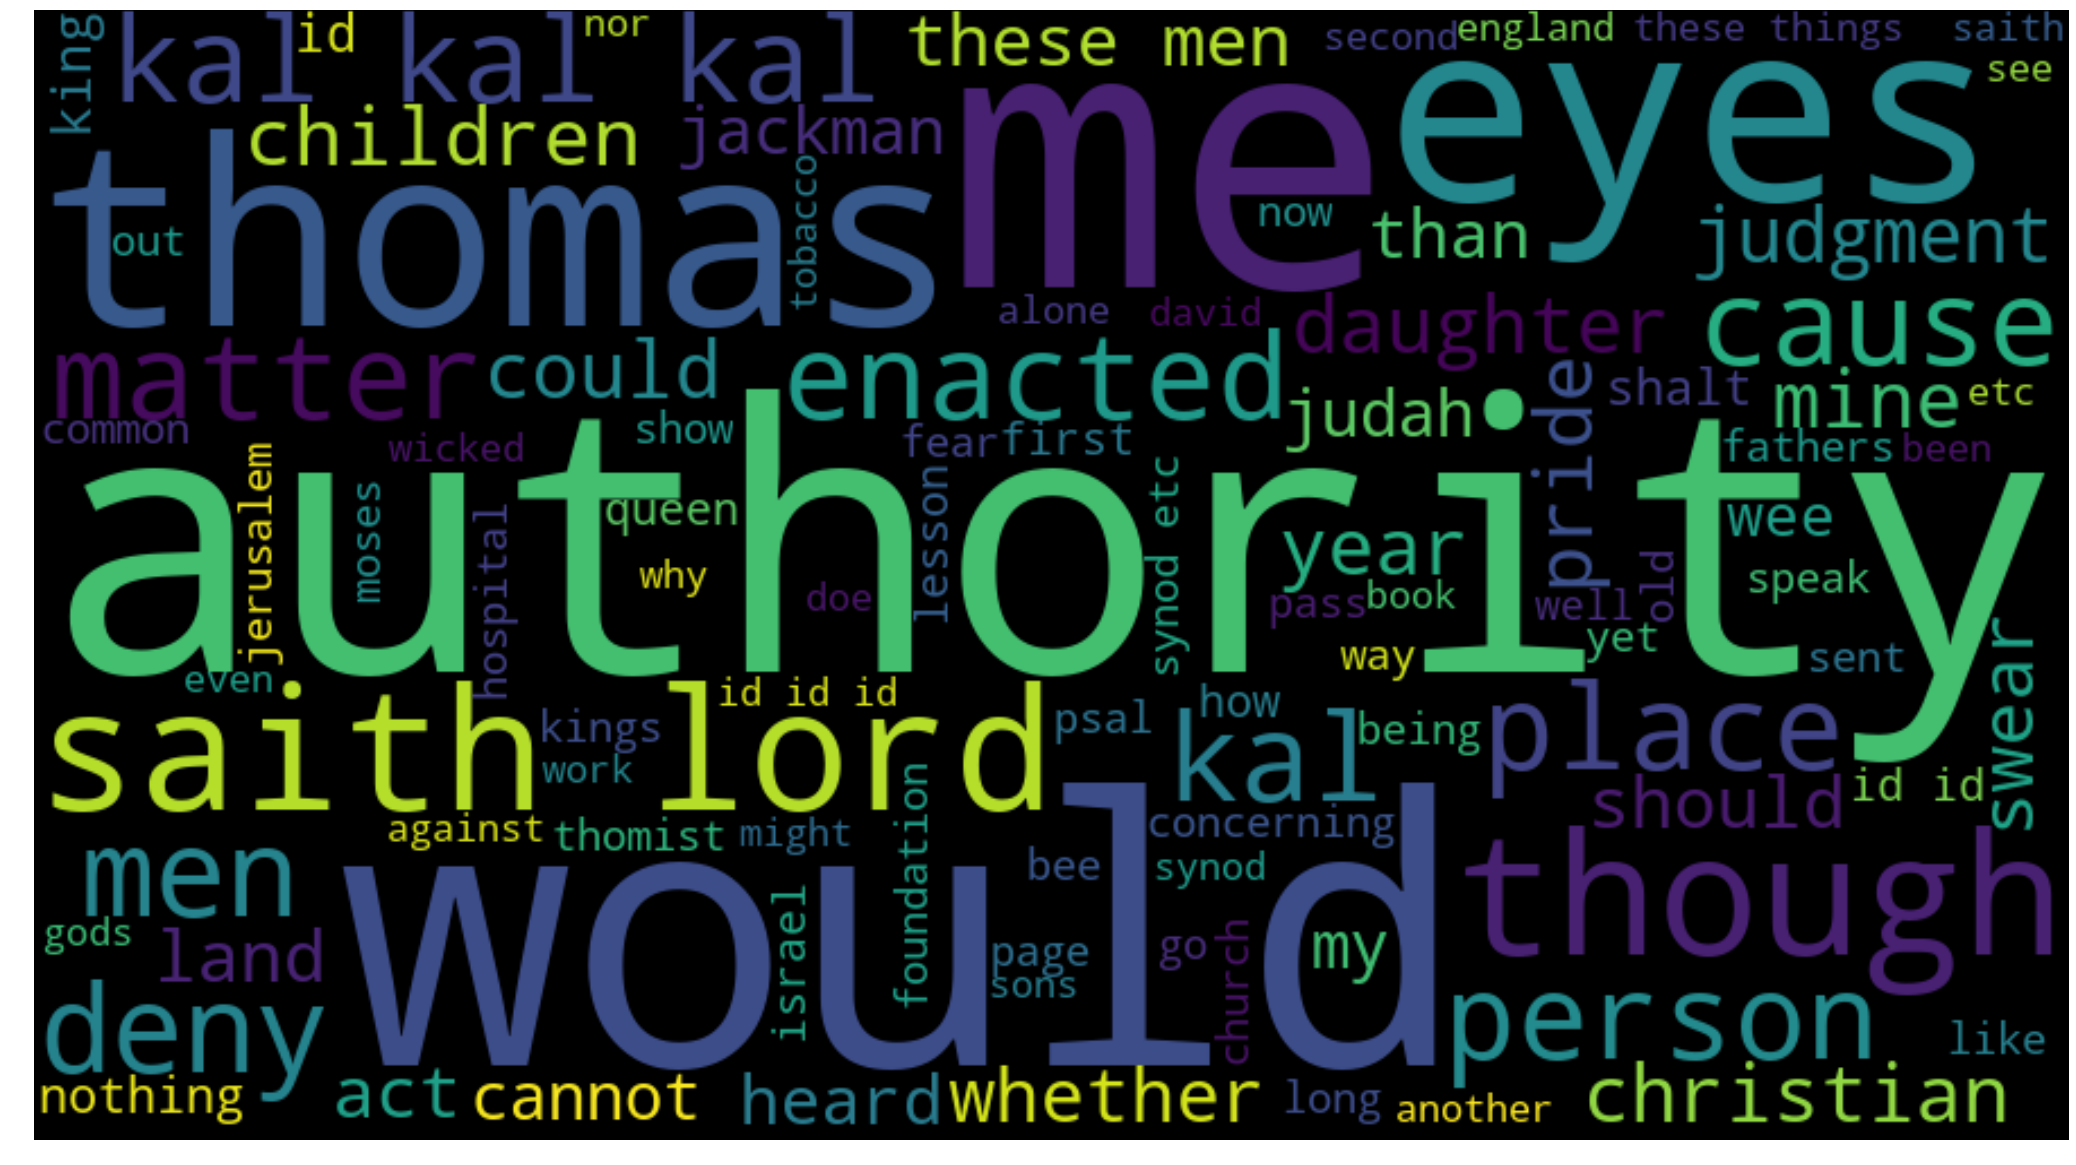

Class: Charles I


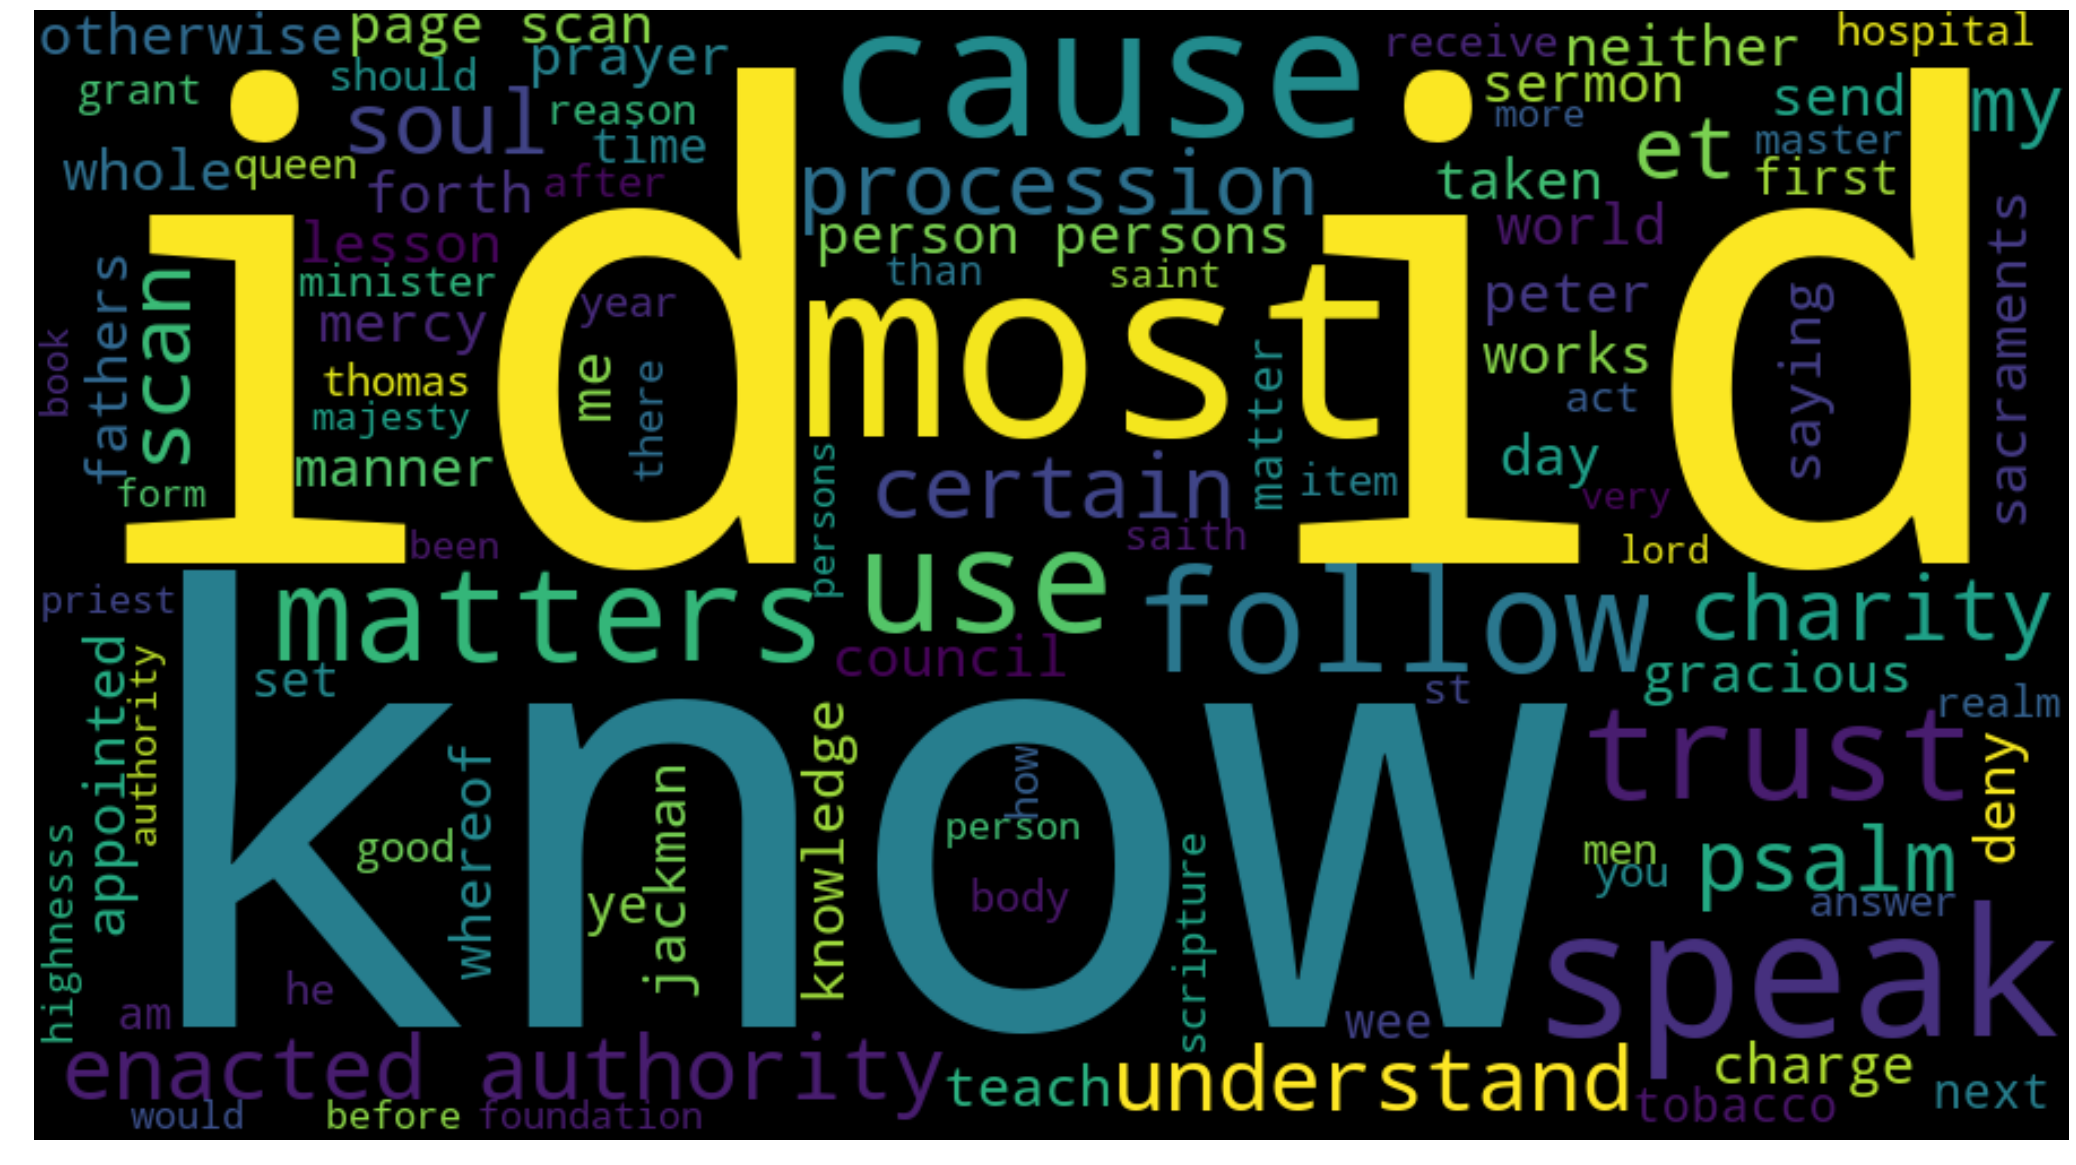

Class: Edward VI


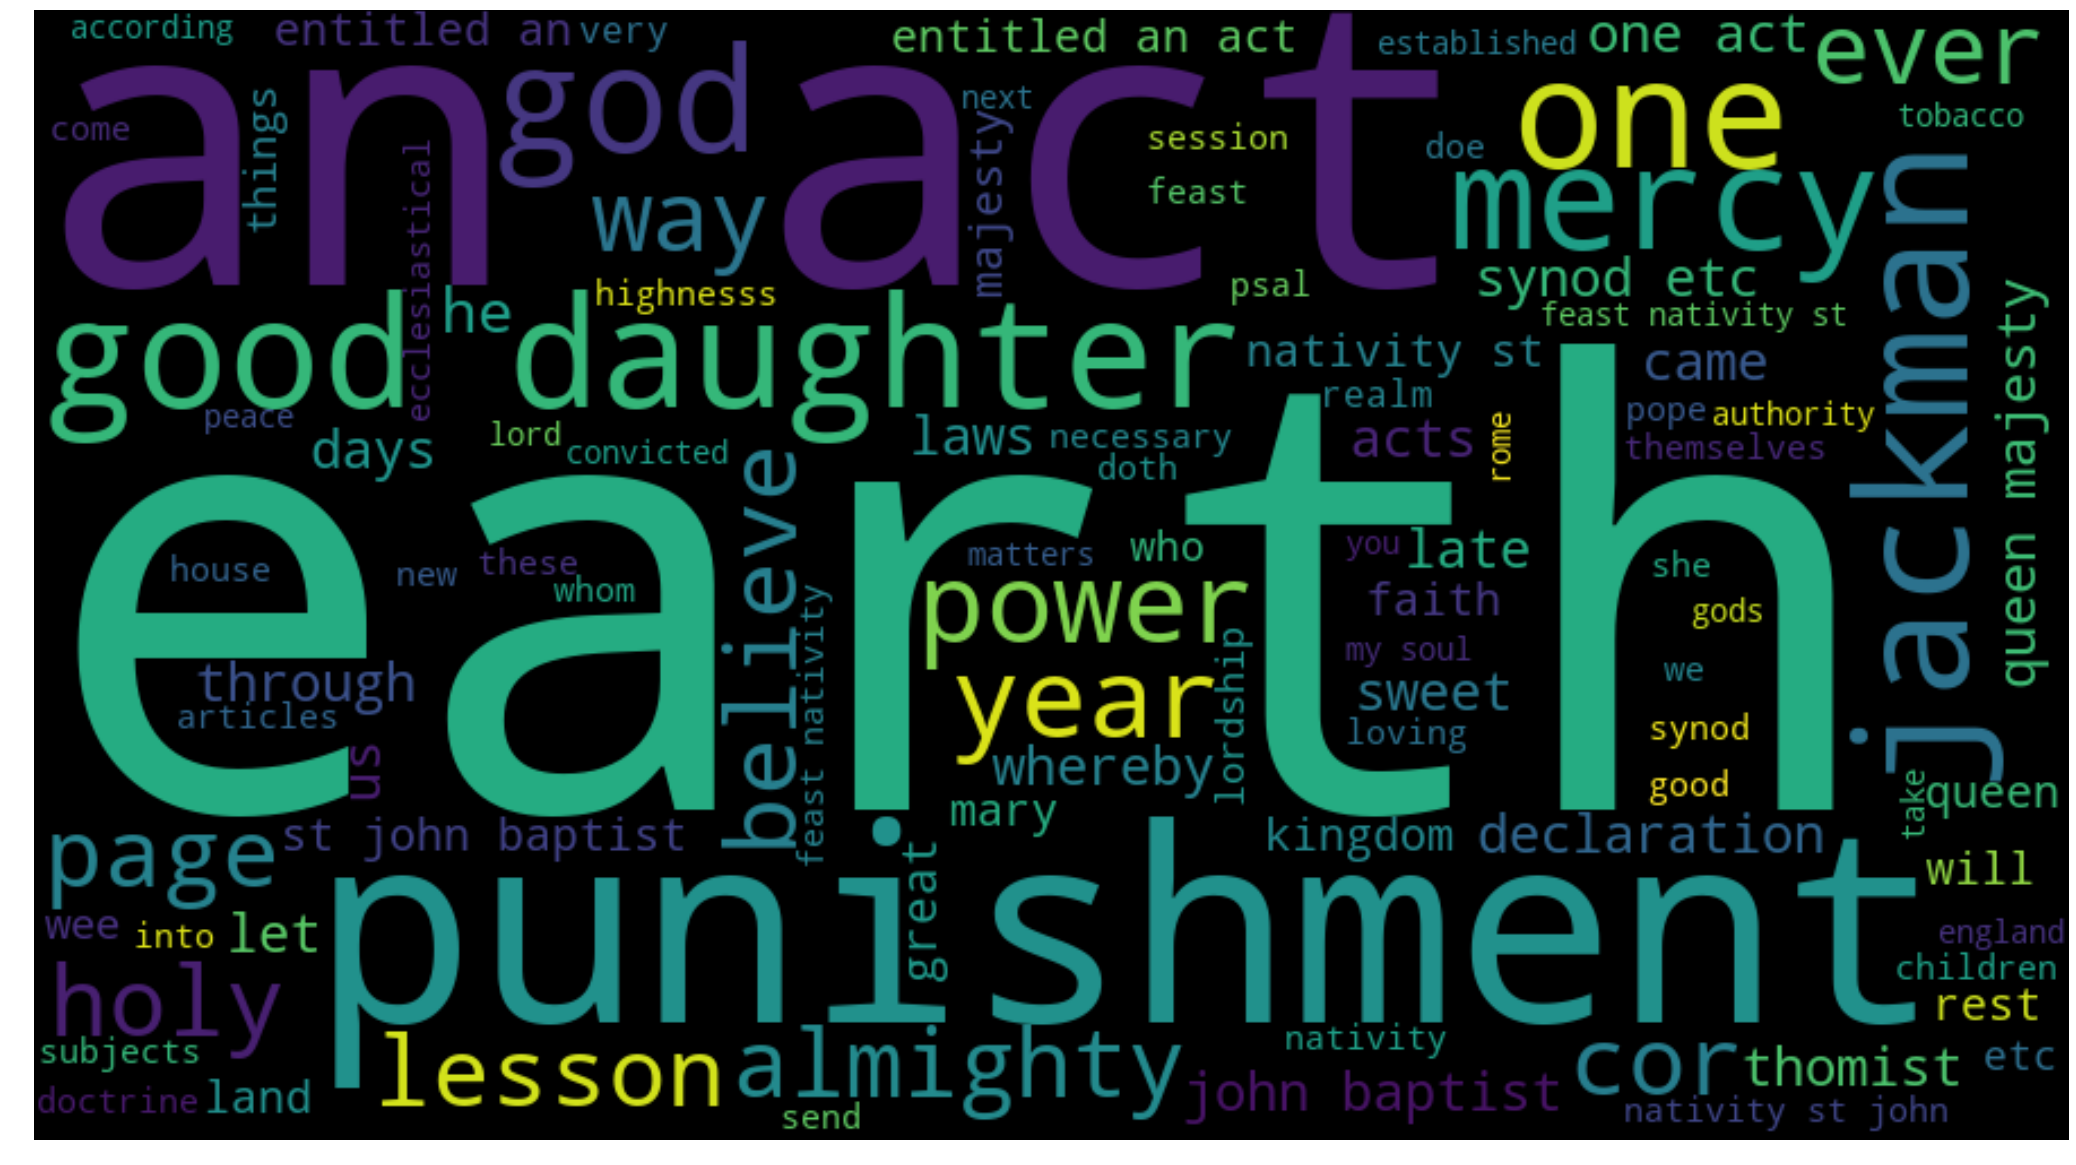

Class: James I


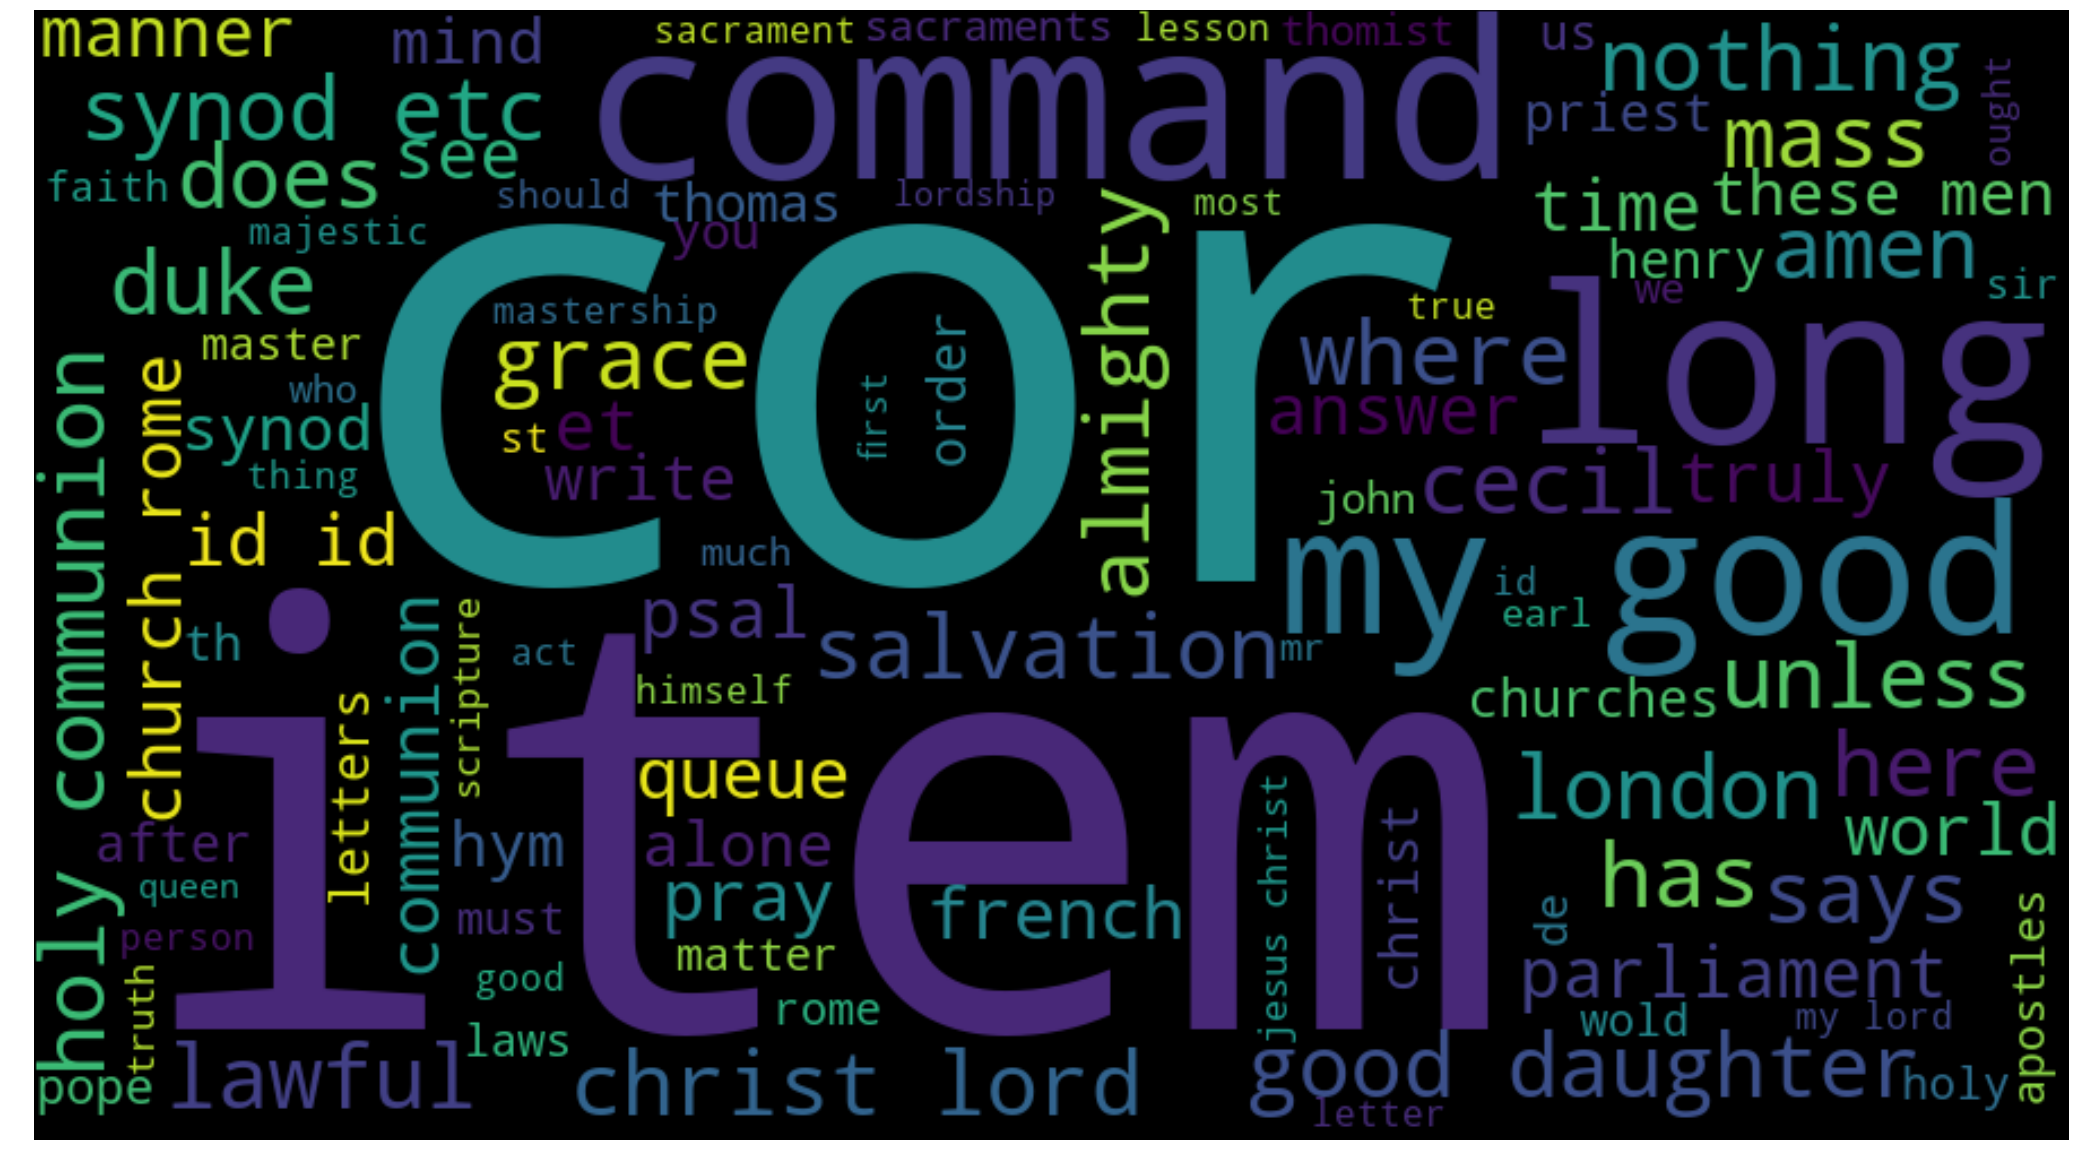

In [11]:
from wordcloud import WordCloud

# show most important features for each class:
for cl in word_cloud_data.keys():
    print("Class: {0}".format(cl))
    fig = plt.figure(figsize=(35, 20), dpi=75)
    wordcloud = WordCloud(width=900,height=500, max_words=1000,
                      relative_scaling=1).generate_from_frequencies(word_cloud_data[cl])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()